# CIS4930 -- Final Project
## Developed by: Chloe Fandino (Team Leader), Ashley James, Madelyne Wirbel, Chloe Nolan, Christopher Enlow

## Data Preprocessing

### Imports

In [1]:
# imports here :)

# TODO: DELETE ---> any imports that don't end up getting used by the end of the project !!!!

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA


from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


from imblearn.over_sampling import SMOTE, SMOTENC

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

### Loading the data

In [2]:
df = pd.read_csv('OnlineNewsPopularity.csv') # import the data from the csv file --> convert to df

### Exploration of the dataset

In [3]:
# pd.set_option('display.max_rows', 100) # for purposes of looking at data --> need to see all rows

# basic intitial looks at the dataset
print(df.shape)

print(df.info())

(39644, 61)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords       

In [4]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

In [5]:
print(df.columns.tolist()) # print out all of the available columns

['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', '

In [6]:
df.isnull().sum() # null values? --> NONE :)

url                             0
timedelta                       0
n_tokens_title                  0
n_tokens_content                0
n_unique_tokens                 0
                               ..
title_subjectivity              0
title_sentiment_polarity        0
abs_title_subjectivity          0
abs_title_sentiment_polarity    0
shares                          0
Length: 61, dtype: int64

In [7]:
df.duplicated().sum() # duplicate values? --> NONE :)

np.int64(0)

In [8]:
# check if any infinities exist in the dataframe
numeric_df = df.select_dtypes(include=[np.number])

has_inf = np.isinf(numeric_df.to_numpy()).any()

print(has_inf) # will need to handle in cleaning
inf_cols = numeric_df.columns[np.isinf(numeric_df.to_numpy()).any(axis=0)].tolist()
print("Columns with inf:", inf_cols)

False
Columns with inf: []


#### Visualization of the target variable --> shares

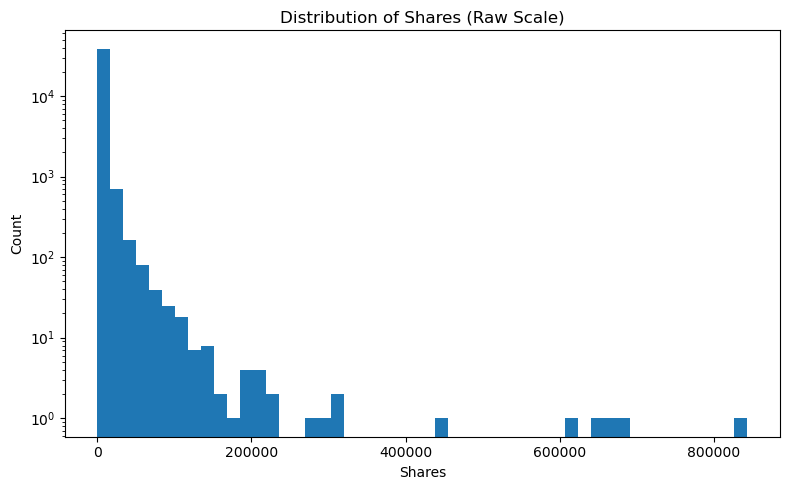

In [9]:
# histogram of shares
plt.figure(figsize=(8, 5))
plt.hist(df["shares"], bins=50)
plt.title("Distribution of Shares (Raw Scale)")
plt.xlabel("Shares")
plt.ylabel("Count")
plt.yscale("log")  # long tail
plt.tight_layout()
plt.show()

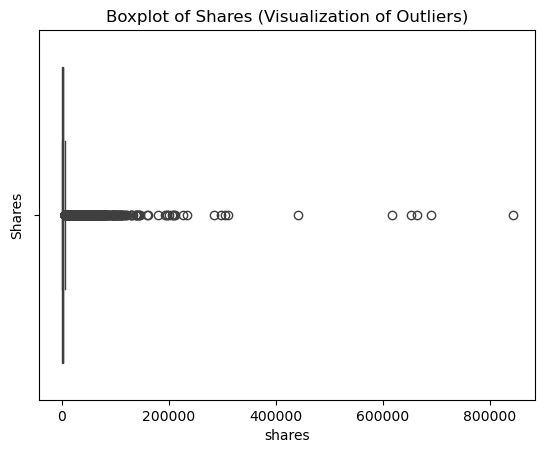

In [10]:
# boxplot of raw shares --> view of the outliers
sns.boxplot(x = df["shares"])
plt.title("Boxplot of Shares (Visualization of Outliers)")
plt.ylabel("Shares")
plt.show()

#### Visualizations of numerical features

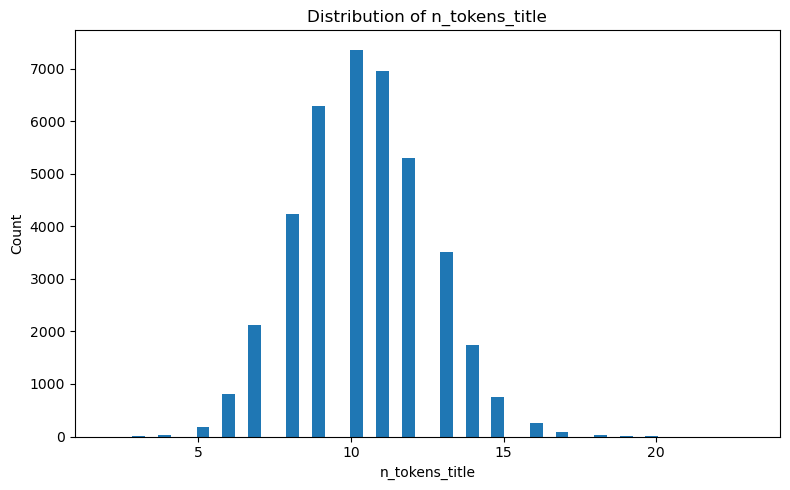

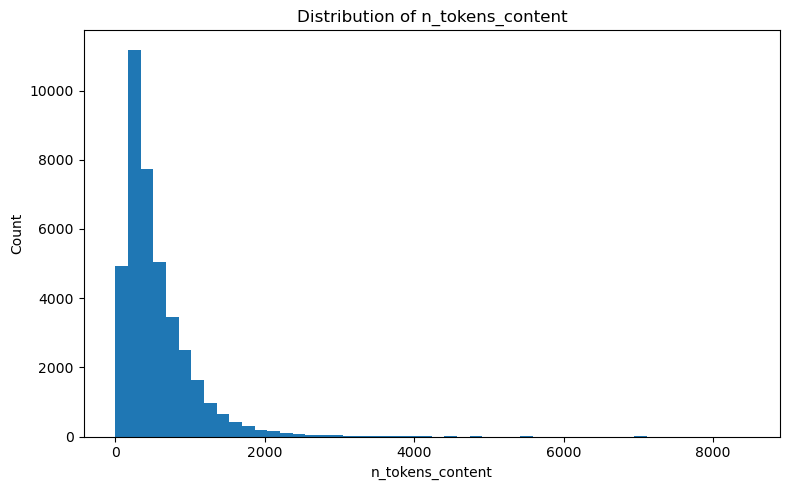

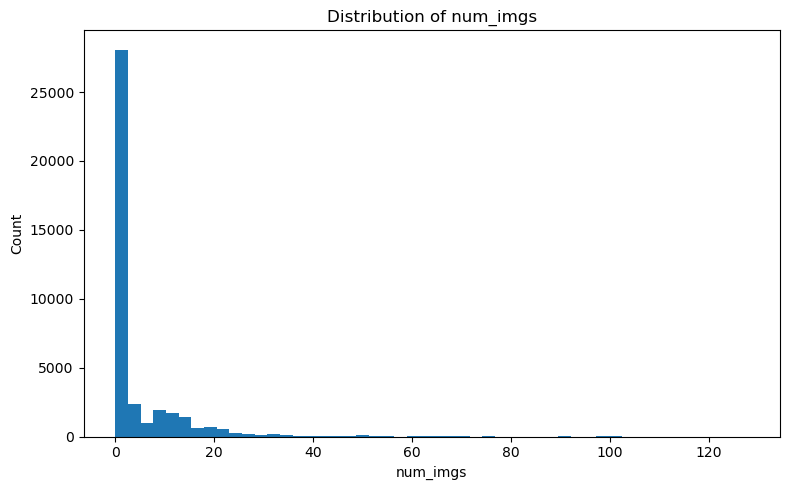

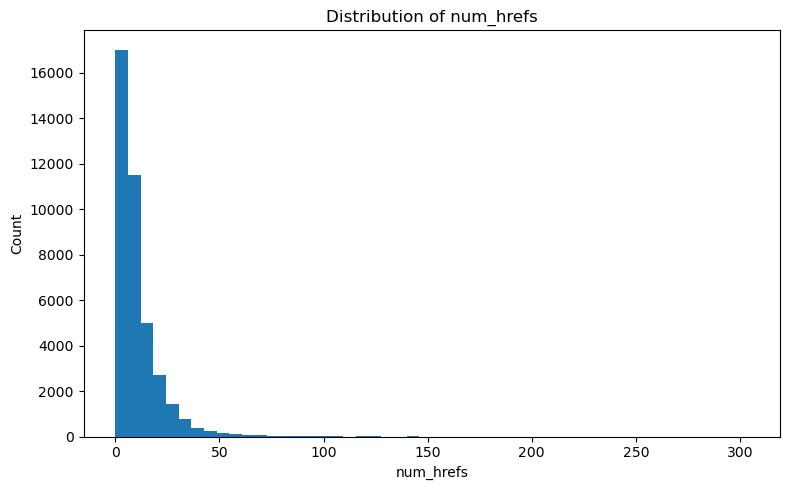

In [11]:
# distribution of key numerical features
key_cols = ["n_tokens_title", "n_tokens_content", "num_imgs", "num_hrefs"]

for col in key_cols:
    plt.figure(figsize=(8, 5))
    plt.hist(df[col], bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

### Cleaning the data

In [12]:
# # exploration of potentially non-predictive features
df = df.drop(columns=['url', 'timedelta'], errors='ignore') # url is a title and number of days since posted until added to the dataset --> no predictive qualities

# feature engineering
df['rate_positive_words'] = df['global_rate_positive_words'] / (df['n_tokens_content'] + 1)
df['rate_negative_words'] = df['global_rate_negative_words'] / (df['n_tokens_content'] + 1)
df['emotional_polarity'] = df['global_sentiment_polarity'].abs()
df['title_body_sentiment_ratio'] = df['title_sentiment_polarity'] / (df['global_sentiment_polarity'] + 0.01)

In [13]:
# Splitting data in two --> based on median
median_shares = df['shares'].median()
print(f"Splitting data at median shares: {median_shares}")

def categorize(x):
    return 1 if x > median_shares else 0

df['y'] = df['shares'].apply(categorize)

# define X and y 
X = df.drop(columns=['shares', 'y'])
y = df['y']

binary_cols = [col for col in X.columns if "data_channel" in col or "weekday" in col or "is_weekend" in col]
# ensure binary cols are actually integers
for col in binary_cols:
    X[col] = X[col].astype(int)

numeric_cols = [col for col in X.columns if col not in binary_cols]

Splitting data at median shares: 1400.0


In [14]:
# --> test-train-split <-- DO NOT EDIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

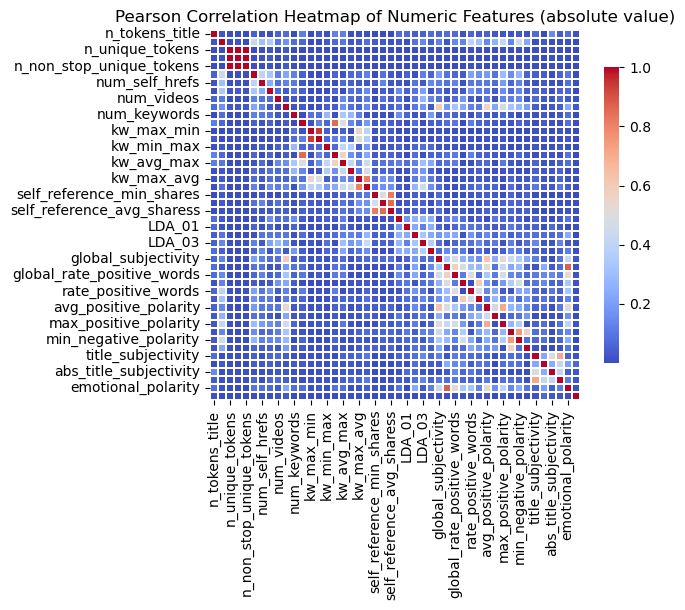

Dropping 6 columns due to correlation: ['n_non_stop_words', 'n_non_stop_unique_tokens', 'kw_avg_min', 'kw_max_max', 'self_reference_avg_sharess', 'emotional_polarity']


In [15]:
#CHLOE pearson correlation coefficient
corr_matrix = X_train[numeric_cols].corr(method='pearson').abs()

# visualization of highly correlated features
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=False,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8},
    square=True
)
plt.title("Pearson Correlation Heatmap of Numeric Features (absolute value)")
plt.show()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

print(f"Dropping {len(to_drop)} columns due to correlation: {to_drop}")

X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
numeric_cols = [c for c in numeric_cols if c not in to_drop]

#### Anomaly Detection

In [16]:
# function to visualize and count anomalies
def anomaly_detection(feature, visualize):
    # first boxplot to see potential outliers
    if visualize:
        sns.boxplot(x = df[feature], color = 'purple')
        plt.title(feature)
        plt.show()

    # second calculate outliers based on IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)

    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    anomalies = df[(df[feature] < lower) | (df[feature] > upper)]
    print('Anomalies: \n', anomalies) # prints a list of potential anomalies

    num_anomalies = anomalies.shape[0]
    return num_anomalies

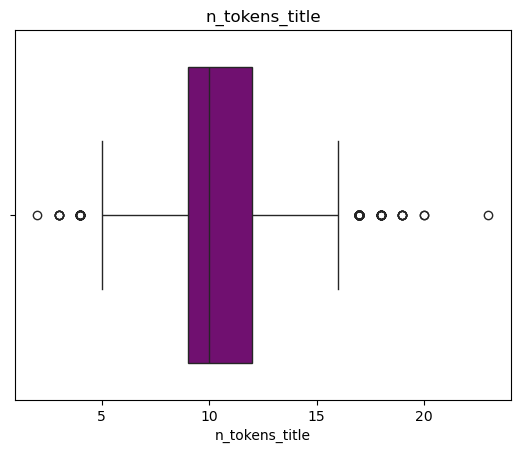

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
588              18.0             355.0         0.551429               1.0   
629               4.0             297.0         0.613014               1.0   
804              18.0             537.0         0.488722               1.0   
861              17.0             141.0         0.770370               1.0   
993               4.0              98.0         0.670213               1.0   
...               ...               ...              ...               ...   
39308            17.0             557.0         0.486388               1.0   
39323            19.0            1140.0         0.394595               1.0   
39390             4.0             589.0         0.509910               1.0   
39460            17.0             262.0         0.605578               1.0   
39534            18.0             406.0         0.587065               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

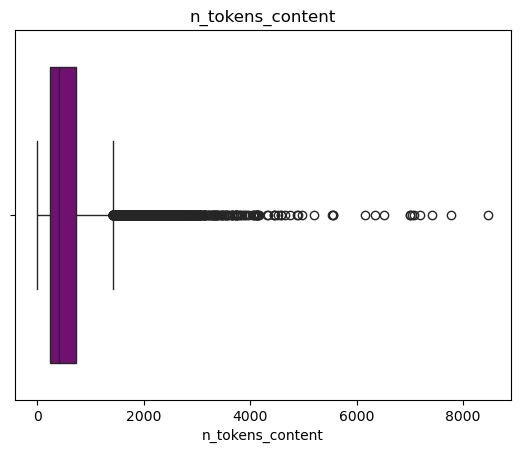

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
140              12.0            1455.0         0.419825               1.0   
141              10.0            1596.0         0.419729               1.0   
316               9.0            1438.0         0.466054               1.0   
336               9.0            1821.0         0.373687               1.0   
393               8.0            1579.0         0.383684               1.0   
...               ...               ...              ...               ...   
39524            15.0            1456.0         0.454674               1.0   
39529            11.0            2377.0         0.241247               1.0   
39593            13.0            1848.0         0.396694               1.0   
39636             8.0            2509.0         0.348878               1.0   
39637            13.0            1629.0         0.425711               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

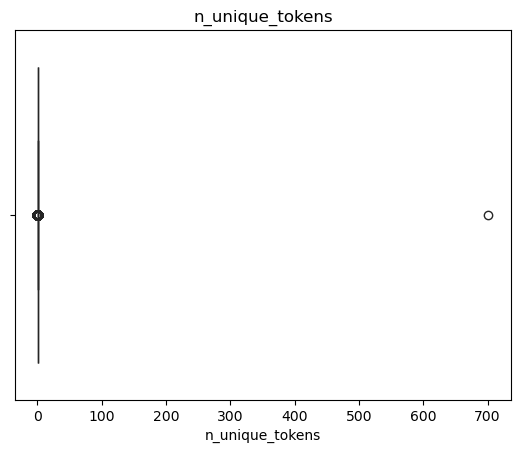

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
57                8.0             130.0         0.821705               1.0   
127               7.0             105.0         0.819048               1.0   
243              12.0              62.0         0.887097               1.0   
244               8.0              75.0         0.853333               1.0   
340              16.0              83.0         0.843373               1.0   
...               ...               ...              ...               ...   
39598            11.0               0.0         0.000000               0.0   
39601            12.0               0.0         0.000000               0.0   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

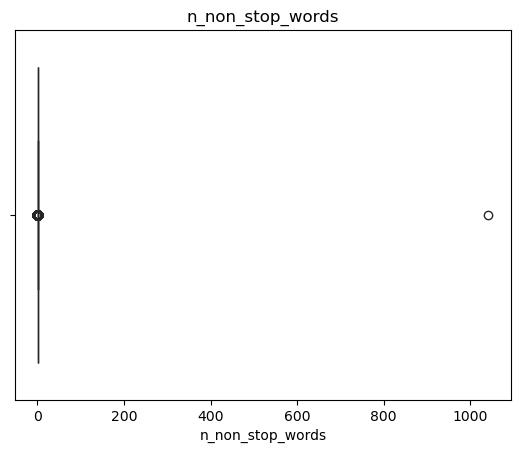

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
8                11.0              97.0         0.670103               1.0   
18               11.0             103.0         0.689320               1.0   
69                6.0             109.0         0.666667               1.0   
100               9.0             142.0         0.714286               1.0   
119               9.0              81.0         0.787500               1.0   
...               ...               ...              ...               ...   
39598            11.0               0.0         0.000000               0.0   
39601            12.0               0.0         0.000000               0.0   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

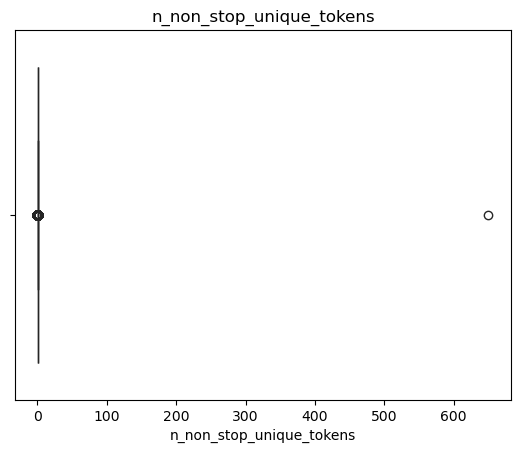

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
244               8.0              75.0         0.853333               1.0   
569               9.0             436.0         0.375870               1.0   
638               7.0              22.0         0.954545               1.0   
717              10.0            1231.0         0.284843               1.0   
773               7.0             524.0         0.309237               1.0   
...               ...               ...              ...               ...   
39598            11.0               0.0         0.000000               0.0   
39601            12.0               0.0         0.000000               0.0   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

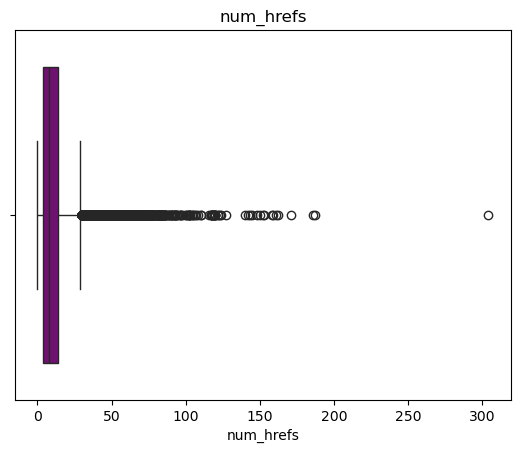

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
98                7.0            1174.0         0.457904               1.0   
103               6.0            1125.0         0.427788               1.0   
140              12.0            1455.0         0.419825               1.0   
147               8.0             794.0         0.503177               1.0   
174              11.0             277.0         0.450185               1.0   
...               ...               ...              ...               ...   
39512            10.0            1058.0         0.404082               1.0   
39558            11.0             428.0         0.559406               1.0   
39596            12.0             270.0         0.594378               1.0   
39612            11.0             735.0         0.505698               1.0   
39617            11.0             991.0         0.459173               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

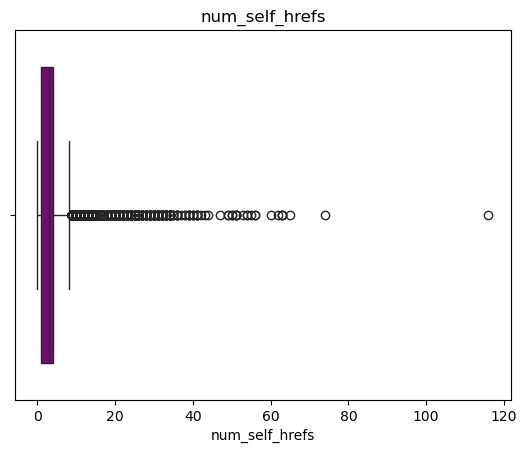

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
4                13.0            1072.0         0.415646               1.0   
6                 8.0             960.0         0.418163               1.0   
7                12.0             989.0         0.433574               1.0   
16                8.0            1118.0         0.512397               1.0   
19                8.0            1207.0         0.410579               1.0   
...               ...               ...              ...               ...   
39532            13.0             961.0         0.499468               1.0   
39606             9.0            1006.0         0.429000               1.0   
39618            14.0             488.0         0.517454               1.0   
39634             9.0             251.0         0.666667               1.0   
39637            13.0            1629.0         0.425711               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

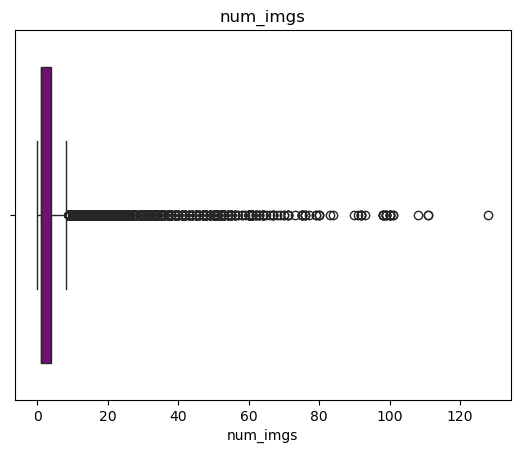

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
4                13.0            1072.0         0.415646               1.0   
6                 8.0             960.0         0.418163               1.0   
7                12.0             989.0         0.433574               1.0   
12                9.0             274.0         0.609195               1.0   
14                8.0             259.0         0.562753               1.0   
...               ...               ...              ...               ...   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39634             9.0             251.0         0.666667               1.0   
39636             8.0            2509.0         0.348878               1.0   
39641            10.0             442.0         0.516355               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

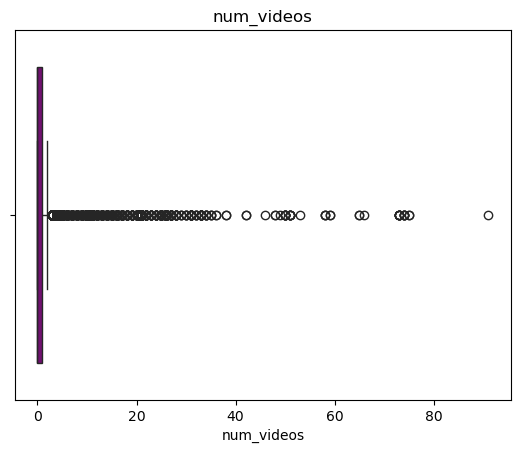

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
13                9.0             285.0         0.744186               1.0   
47               12.0             161.0         0.668831               1.0   
99                7.0             376.0         0.569014               1.0   
126               8.0             270.0         0.600775               1.0   
129              10.0             254.0         0.627530               1.0   
...               ...               ...              ...               ...   
39529            11.0            2377.0         0.241247               1.0   
39556            12.0             979.0         0.480126               1.0   
39575            13.0             321.0         0.619048               1.0   
39600            11.0            1166.0         0.508254               1.0   
39640            12.0             328.0         0.696296               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

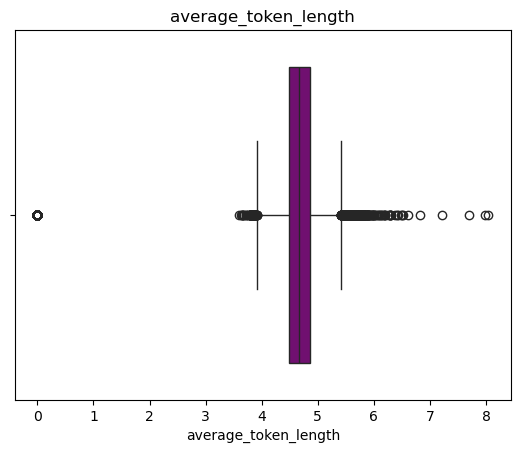

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
17                8.0             397.0         0.624679               1.0   
187               7.0             175.0         0.685714               1.0   
234               7.0             665.0         0.595166               1.0   
242              11.0             149.0         0.673913               1.0   
402              12.0             324.0         0.573248               1.0   
...               ...               ...              ...               ...   
39598            11.0               0.0         0.000000               0.0   
39601            12.0               0.0         0.000000               0.0   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

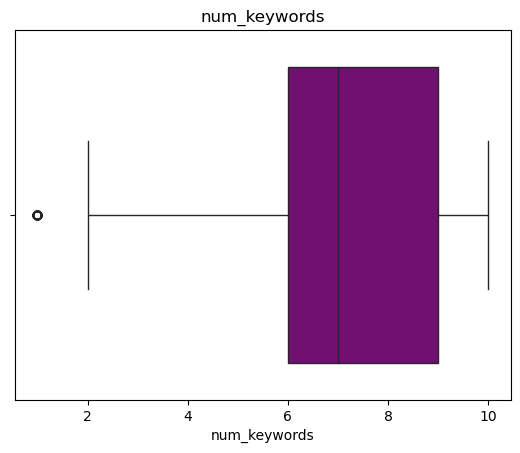

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
1507             11.0             391.0         0.551282               1.0   
1568              9.0             539.0         0.545966               1.0   
2199              9.0             192.0         0.578125               1.0   
3159              8.0             614.0         0.537705               1.0   
4306              9.0            1324.0         0.440154               1.0   
4651              9.0            1214.0         0.458264               1.0   
4868              6.0             139.0         0.625899               1.0   
5234             13.0             146.0         0.753425               1.0   
5617              9.0             463.0         0.543860               1.0   
5771             10.0             128.0         0.724409               1.0   
6320             10.0             822.0         0.480697               1.0   
6395              8.0             481.0         0.5

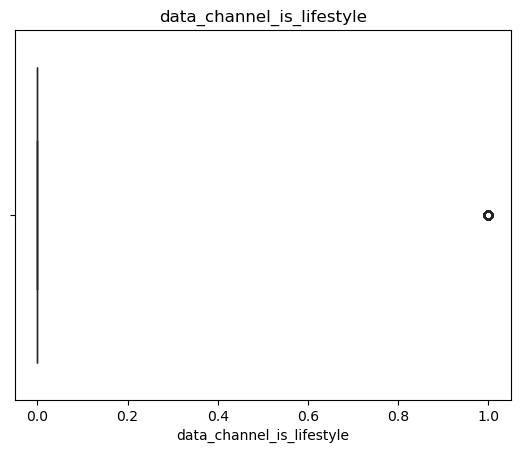

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
6                 8.0             960.0         0.418163               1.0   
11               10.0             187.0         0.666667               1.0   
18               11.0             103.0         0.689320               1.0   
28               10.0             243.0         0.619247               1.0   
34                8.0             204.0         0.586207               1.0   
...               ...               ...              ...               ...   
39557            12.0             908.0         0.455556               1.0   
39596            12.0             270.0         0.594378               1.0   
39599            11.0             610.0         0.510888               1.0   
39608            11.0             575.0         0.530466               1.0   
39636             8.0            2509.0         0.348878               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

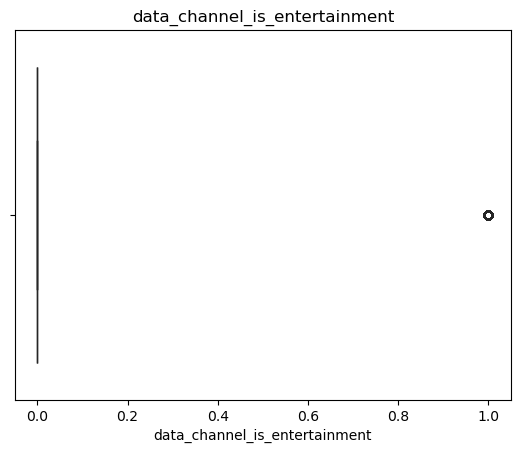

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                12.0             219.0         0.663594               1.0   
3                 9.0             531.0         0.503788               1.0   
39               14.0             194.0         0.764706               1.0   
47               12.0             161.0         0.668831               1.0   
53               11.0             454.0         0.566079               1.0   
...               ...               ...              ...               ...   
39592            11.0             233.0         0.585903               1.0   
39602             9.0             475.0         0.558242               1.0   
39629            13.0             209.0         0.656863               1.0   
39637            13.0            1629.0         0.425711               1.0   
39643            10.0             157.0         0.701987               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

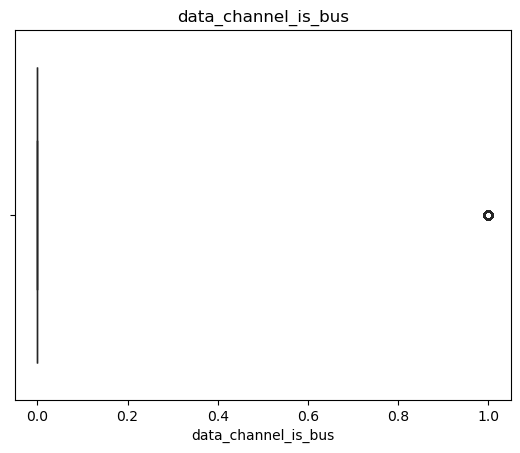

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
1                 9.0             255.0         0.604743               1.0   
2                 9.0             211.0         0.575130               1.0   
17                8.0             397.0         0.624679               1.0   
24               13.0             244.0         0.560000               1.0   
29               11.0             723.0         0.490934               1.0   
...               ...               ...              ...               ...   
39600            11.0            1166.0         0.508254               1.0   
39603            15.0             426.0         0.540284               1.0   
39604            16.0            1020.0         0.421937               1.0   
39635            13.0             478.0         0.514039               1.0   
39638            11.0             223.0         0.653153               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

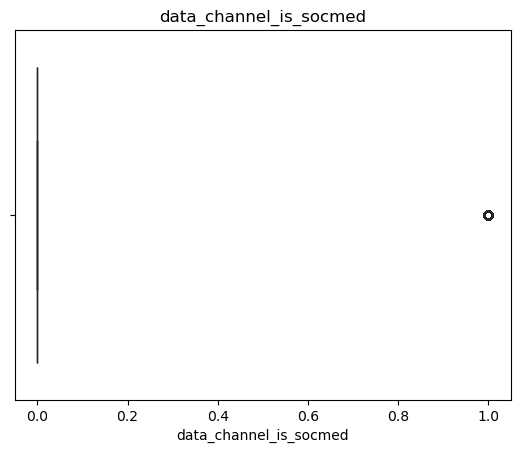

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
37                8.0             257.0         0.568093               1.0   
73                8.0             218.0         0.662983               1.0   
77                9.0            1226.0         0.410172               1.0   
78               10.0            1121.0         0.450679               1.0   
96                9.0             168.0         0.778481               1.0   
...               ...               ...              ...               ...   
39493             9.0             774.0         0.524183               1.0   
39503            12.0             590.0         0.513465               1.0   
39561            13.0             425.0         0.487059               1.0   
39575            13.0             321.0         0.619048               1.0   
39640            12.0             328.0         0.696296               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

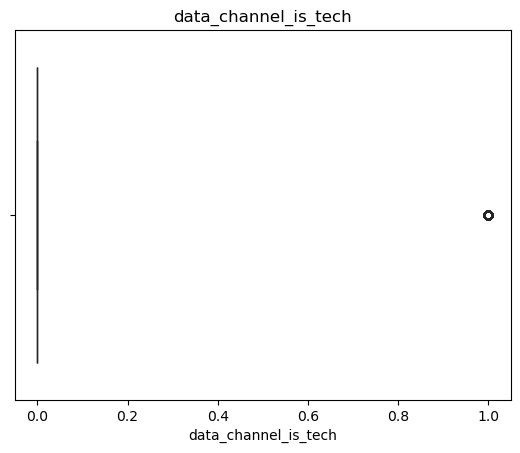

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
4                13.0            1072.0         0.415646               1.0   
5                10.0             370.0         0.559889               1.0   
7                12.0             989.0         0.433574               1.0   
8                11.0              97.0         0.670103               1.0   
19                8.0            1207.0         0.410579               1.0   
...               ...               ...              ...               ...   
39623            14.0             436.0         0.529412               1.0   
39624            12.0             429.0         0.514925               1.0   
39625            13.0             224.0         0.570136               1.0   
39626            12.0             249.0         0.567227               1.0   
39639            11.0             346.0         0.529052               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

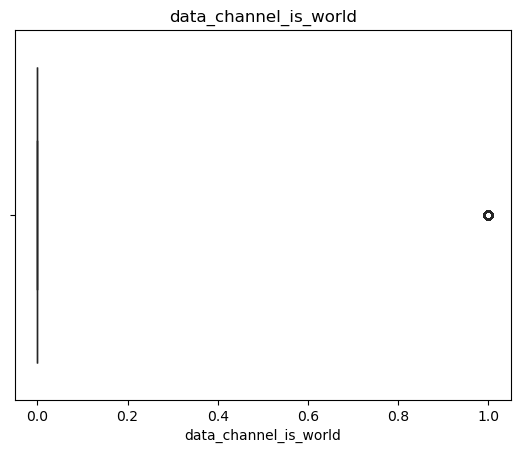

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
9                10.0             231.0         0.636364               1.0   
10                9.0            1248.0         0.490050               1.0   
15               12.0             682.0         0.459542               1.0   
21                9.0             391.0         0.510256               1.0   
23               11.0             125.0         0.674797               1.0   
...               ...               ...              ...               ...   
39630            12.0             491.0         0.454167               1.0   
39631            13.0             746.0         0.465306               1.0   
39632            15.0             580.0         0.506261               1.0   
39633             9.0             614.0         0.476033               1.0   
39642             6.0             682.0         0.539493               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

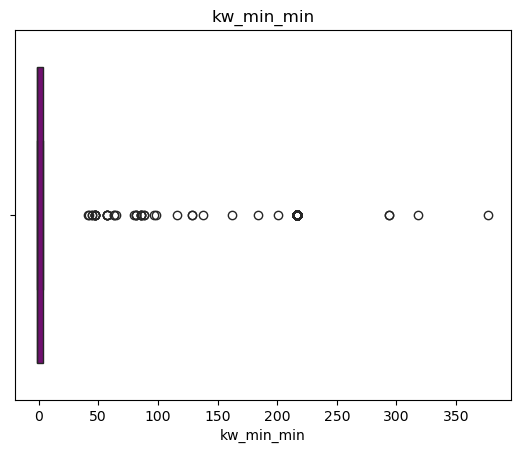

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
79               12.0             288.0         0.589474               1.0   
80               10.0             414.0         0.606796               1.0   
81               11.0             134.0         0.702290               1.0   
82               11.0             281.0         0.610714               1.0   
83               12.0             499.0         0.513026               1.0   
...               ...               ...              ...               ...   
21827             8.0             491.0         0.492754               1.0   
23088            12.0             820.0         0.452645               1.0   
23257            10.0             232.0         0.495370               1.0   
23325            10.0             293.0         0.582734               1.0   
23691             7.0             328.0         0.640678               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

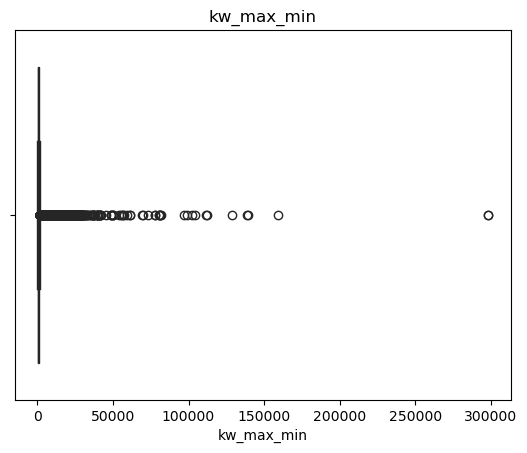

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
87               13.0             306.0         0.534653               1.0   
100               9.0             142.0         0.714286               1.0   
104              10.0             498.0         0.534979               1.0   
107              11.0             223.0         0.662162               1.0   
109               7.0            1007.0         0.437751               1.0   
...               ...               ...              ...               ...   
39581            11.0            1066.0         0.461538               1.0   
39587            13.0             364.0         0.538462               1.0   
39590            11.0            1143.0         0.450088               1.0   
39621             9.0             468.0         0.582781               1.0   
39625            13.0             224.0         0.570136               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

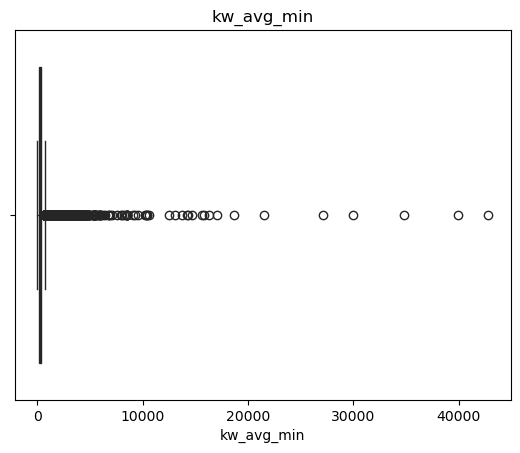

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
87               13.0             306.0         0.534653               1.0   
100               9.0             142.0         0.714286               1.0   
104              10.0             498.0         0.534979               1.0   
107              11.0             223.0         0.662162               1.0   
109               7.0            1007.0         0.437751               1.0   
...               ...               ...              ...               ...   
39517            12.0            1002.0         0.444329               1.0   
39518            14.0             932.0         0.501650               1.0   
39520            10.0             572.0         0.521739               1.0   
39531             7.0             763.0         0.492578               1.0   
39587            13.0             364.0         0.538462               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

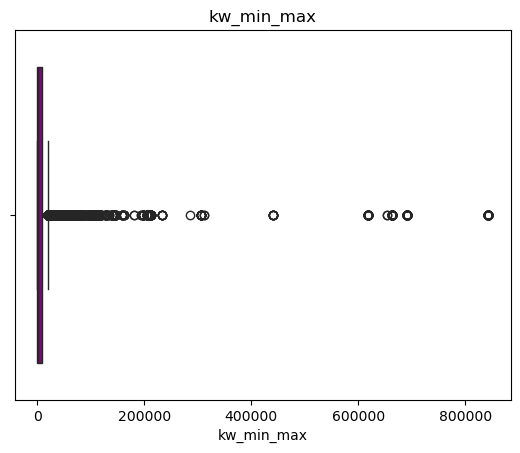

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
400              10.0             342.0         0.606707               1.0   
448              12.0             803.0         0.496241               1.0   
571               7.0             340.0         0.587537               1.0   
573              10.0             311.0         0.659091               1.0   
602              14.0             326.0         0.553125               1.0   
...               ...               ...              ...               ...   
39629            13.0             209.0         0.656863               1.0   
39631            13.0             746.0         0.465306               1.0   
39636             8.0            2509.0         0.348878               1.0   
39639            11.0             346.0         0.529052               1.0   
39643            10.0             157.0         0.701987               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

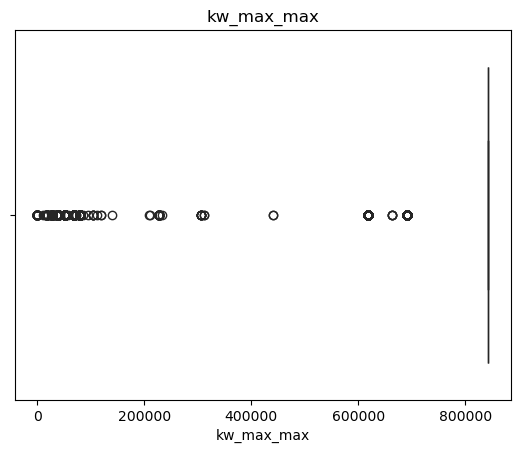

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                12.0             219.0         0.663594               1.0   
1                 9.0             255.0         0.604743               1.0   
2                 9.0             211.0         0.575130               1.0   
3                 9.0             531.0         0.503788               1.0   
4                13.0            1072.0         0.415646               1.0   
...               ...               ...              ...               ...   
29853            10.0            1931.0         0.433438               1.0   
33009            11.0             825.0         0.362595               1.0   
35865            10.0               0.0         0.000000               0.0   
39147            11.0            1467.0         0.432056               1.0   
39155            13.0            1513.0         0.422043               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

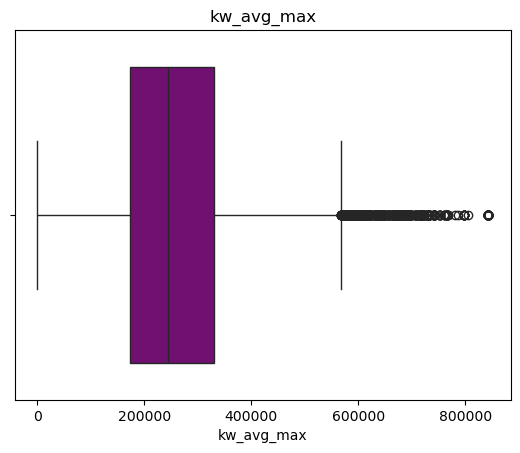

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
3159              8.0             614.0         0.537705               1.0   
4306              9.0            1324.0         0.440154               1.0   
4582             11.0             310.0         0.719858               1.0   
4651              9.0            1214.0         0.458264               1.0   
4855             13.0             147.0         0.734694               1.0   
...               ...               ...              ...               ...   
39538             9.0               0.0         0.000000               0.0   
39560             9.0             261.0         0.620553               1.0   
39600            11.0            1166.0         0.508254               1.0   
39601            12.0               0.0         0.000000               0.0   
39626            12.0             249.0         0.567227               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

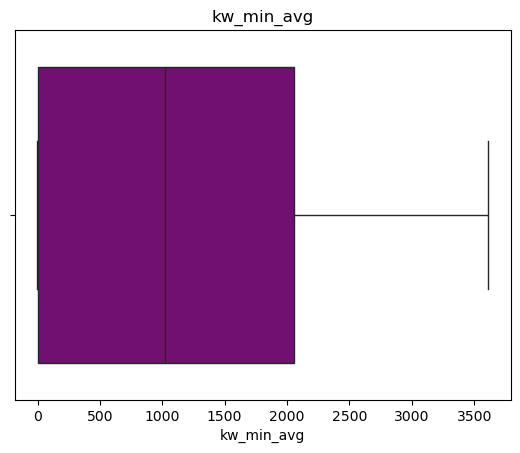

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

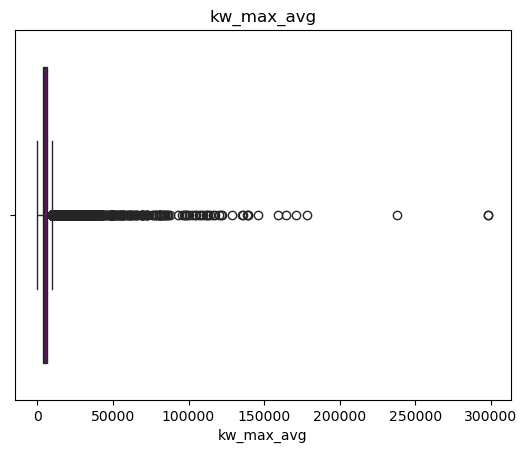

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
113              11.0             825.0         0.476601               1.0   
126               8.0             270.0         0.600775               1.0   
137              13.0             281.0         0.605263               1.0   
145              10.0             138.0         0.753731               1.0   
176              14.0             114.0         0.800000               1.0   
...               ...               ...              ...               ...   
39520            10.0             572.0         0.521739               1.0   
39531             7.0             763.0         0.492578               1.0   
39537             9.0             174.0         0.726190               1.0   
39586            12.0             318.0         0.553398               1.0   
39629            13.0             209.0         0.656863               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

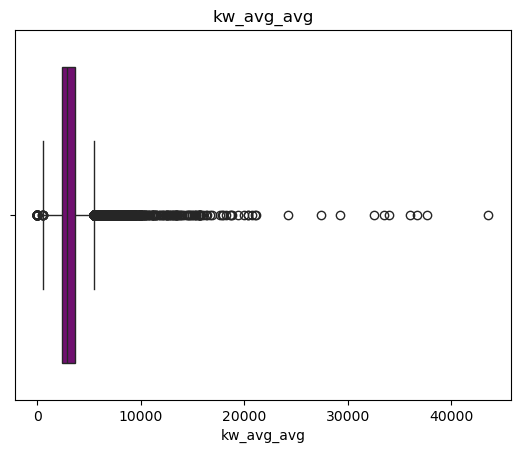

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                12.0             219.0         0.663594               1.0   
1                 9.0             255.0         0.604743               1.0   
2                 9.0             211.0         0.575130               1.0   
3                 9.0             531.0         0.503788               1.0   
4                13.0            1072.0         0.415646               1.0   
...               ...               ...              ...               ...   
39541            11.0               0.0         0.000000               0.0   
39569            15.0               0.0         0.000000               0.0   
39586            12.0             318.0         0.553398               1.0   
39588            10.0             759.0         0.523352               1.0   
39601            12.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

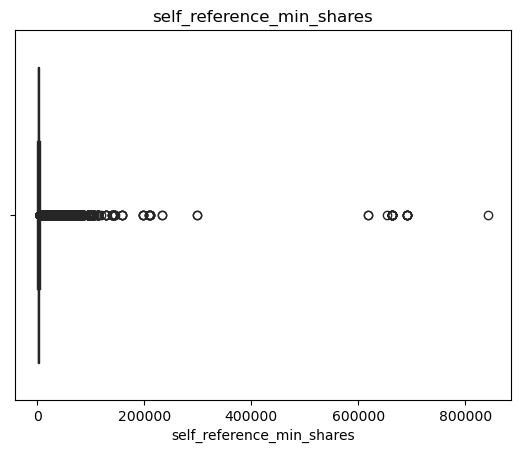

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
5                10.0             370.0         0.559889               1.0   
12                9.0             274.0         0.609195               1.0   
23               11.0             125.0         0.674797               1.0   
30                8.0             708.0         0.482219               1.0   
35               11.0             315.0         0.551282               1.0   
...               ...               ...              ...               ...   
39607             9.0             376.0         0.545190               1.0   
39611            12.0             270.0         0.604651               1.0   
39621             9.0             468.0         0.582781               1.0   
39635            13.0             478.0         0.514039               1.0   
39639            11.0             346.0         0.529052               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

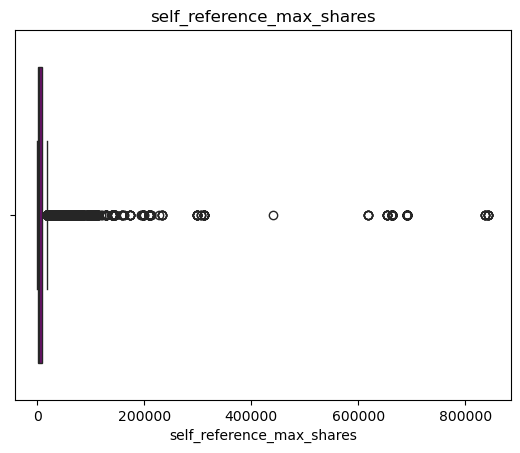

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
13                9.0             285.0         0.744186               1.0   
47               12.0             161.0         0.668831               1.0   
88               10.0             909.0         0.449612               1.0   
117               7.0             346.0         0.564565               1.0   
147               8.0             794.0         0.503177               1.0   
...               ...               ...              ...               ...   
39478            15.0             783.0         0.470817               1.0   
39505            15.0             447.0         0.551570               1.0   
39524            15.0            1456.0         0.454674               1.0   
39621             9.0             468.0         0.582781               1.0   
39639            11.0             346.0         0.529052               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

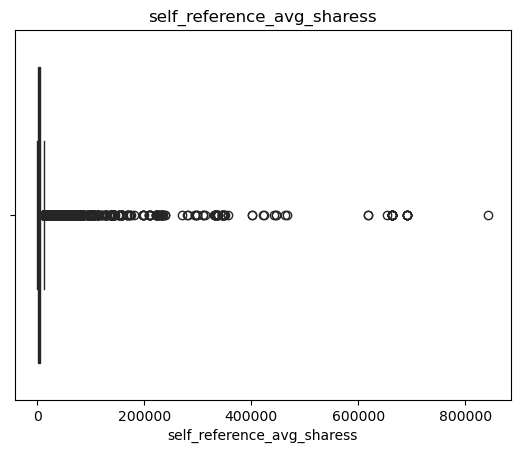

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
12                9.0             274.0         0.609195               1.0   
13                9.0             285.0         0.744186               1.0   
23               11.0             125.0         0.674797               1.0   
88               10.0             909.0         0.449612               1.0   
107              11.0             223.0         0.662162               1.0   
...               ...               ...              ...               ...   
39498            12.0             758.0         0.486188               1.0   
39524            15.0            1456.0         0.454674               1.0   
39607             9.0             376.0         0.545190               1.0   
39621             9.0             468.0         0.582781               1.0   
39639            11.0             346.0         0.529052               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

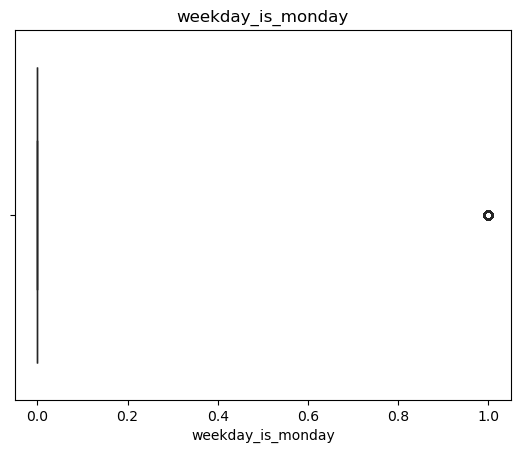

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                12.0             219.0         0.663594               1.0   
1                 9.0             255.0         0.604743               1.0   
2                 9.0             211.0         0.575130               1.0   
3                 9.0             531.0         0.503788               1.0   
4                13.0            1072.0         0.415646               1.0   
...               ...               ...              ...               ...   
39574            13.0             367.0         0.534819               1.0   
39575            13.0             321.0         0.619048               1.0   
39576            12.0             454.0         0.607477               1.0   
39577            11.0             363.0         0.594828               1.0   
39578            11.0             287.0         0.602151               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

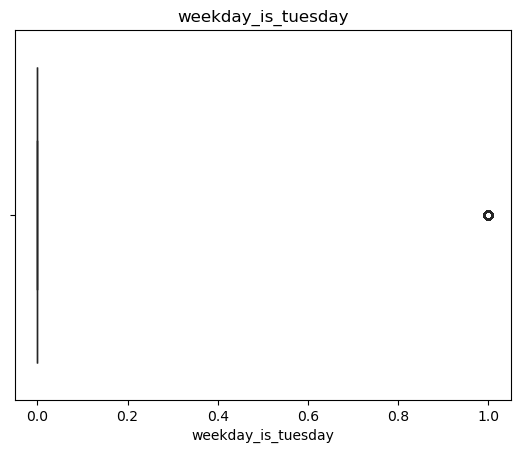

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
79               12.0             288.0         0.589474               1.0   
80               10.0             414.0         0.606796               1.0   
81               11.0             134.0         0.702290               1.0   
82               11.0             281.0         0.610714               1.0   
83               12.0             499.0         0.513026               1.0   
...               ...               ...              ...               ...   
39631            13.0             746.0         0.465306               1.0   
39632            15.0             580.0         0.506261               1.0   
39633             9.0             614.0         0.476033               1.0   
39634             9.0             251.0         0.666667               1.0   
39635            13.0             478.0         0.514039               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

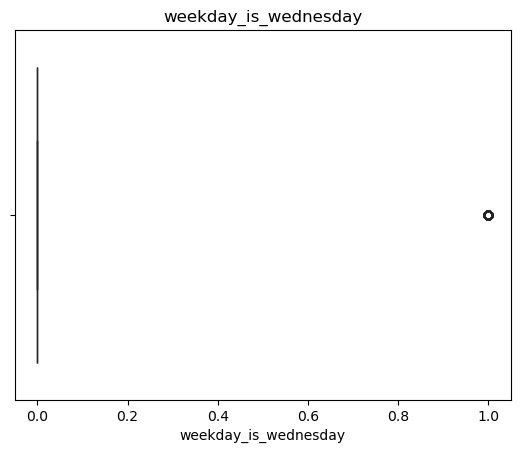

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
91               10.0             413.0         0.606436               1.0   
92                9.0             180.0         0.630058               1.0   
93                9.0             759.0         0.498667               1.0   
94               13.0            1226.0         0.436197               1.0   
95                6.0             241.0         0.659574               1.0   
...               ...               ...              ...               ...   
39639            11.0             346.0         0.529052               1.0   
39640            12.0             328.0         0.696296               1.0   
39641            10.0             442.0         0.516355               1.0   
39642             6.0             682.0         0.539493               1.0   
39643            10.0             157.0         0.701987               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

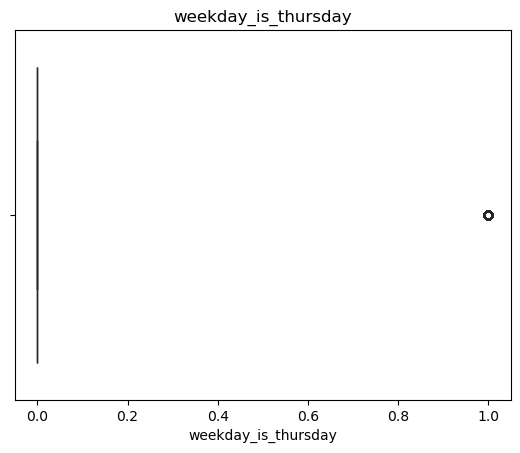

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
180               7.0             144.0         0.591549               1.0   
181               9.0             760.0         0.531629               1.0   
182              13.0             204.0         0.646465               1.0   
183              15.0             481.0         0.541053               1.0   
184              12.0             246.0         0.702128               1.0   
...               ...               ...              ...               ...   
39426            11.0               0.0         0.000000               0.0   
39427            11.0             820.0         0.497512               1.0   
39428            11.0               0.0         0.000000               0.0   
39429             9.0             952.0         0.442797               1.0   
39430            10.0             392.0         0.509333               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

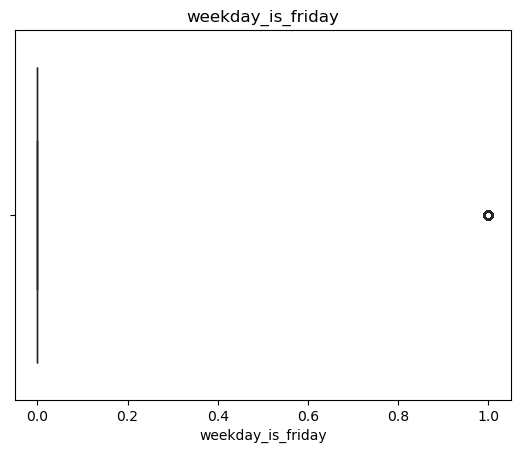

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
260              12.0             698.0         0.498534               1.0   
261              13.0             310.0         0.612457               1.0   
262               8.0             461.0         0.550000               1.0   
263               9.0             318.0         0.579288               1.0   
264              10.0             294.0         0.703008               1.0   
...               ...               ...              ...               ...   
39467            11.0             791.0         0.476882               1.0   
39468            14.0            1025.0         0.465139               1.0   
39469            10.0             559.0         0.539741               1.0   
39470             8.0             996.0         0.485804               1.0   
39471            13.0            1300.0         0.411810               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

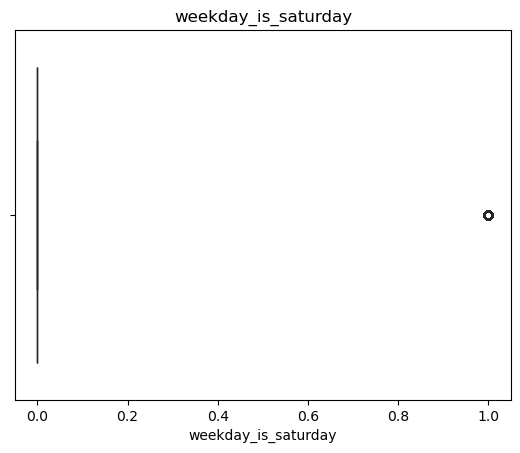

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
311               7.0             203.0         0.668367               1.0   
312              11.0             351.0         0.521490               1.0   
313              11.0             566.0         0.553114               1.0   
314              13.0             297.0         0.532203               1.0   
315               8.0             104.0         0.754902               1.0   
...               ...               ...              ...               ...   
39487            11.0             303.0         0.601351               1.0   
39488            12.0             181.0         0.628571               1.0   
39489            12.0               0.0         0.000000               0.0   
39490            10.0             914.0         0.498343               1.0   
39491             8.0             510.0         0.563636               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

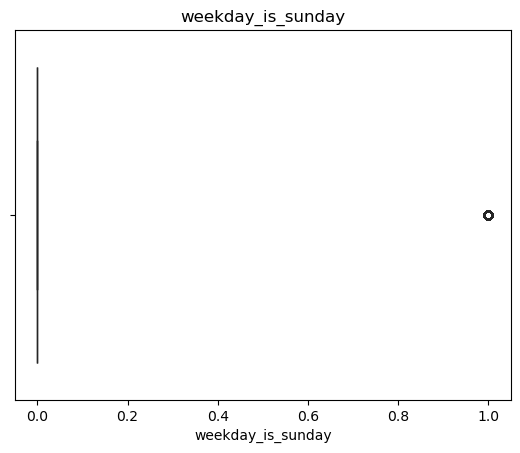

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
331              10.0             996.0         0.490375               1.0   
332              10.0             331.0         0.691318               1.0   
333              10.0             497.0         0.533881               1.0   
334               9.0             678.0         0.493274               1.0   
335               7.0             211.0         0.636364               1.0   
...               ...               ...              ...               ...   
39512            10.0            1058.0         0.404082               1.0   
39513            10.0               0.0         0.000000               0.0   
39514            13.0             813.0         0.415906               1.0   
39515             7.0               0.0         0.000000               0.0   
39516            13.0             936.0         0.426230               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

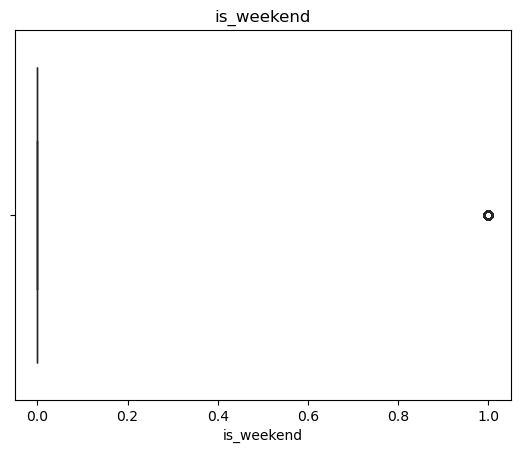

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
311               7.0             203.0         0.668367               1.0   
312              11.0             351.0         0.521490               1.0   
313              11.0             566.0         0.553114               1.0   
314              13.0             297.0         0.532203               1.0   
315               8.0             104.0         0.754902               1.0   
...               ...               ...              ...               ...   
39512            10.0            1058.0         0.404082               1.0   
39513            10.0               0.0         0.000000               0.0   
39514            13.0             813.0         0.415906               1.0   
39515             7.0               0.0         0.000000               0.0   
39516            13.0             936.0         0.426230               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

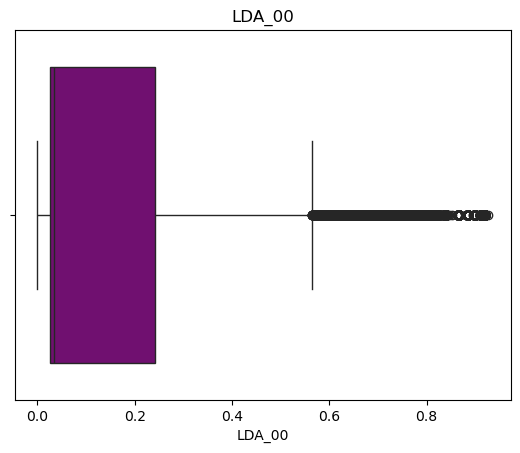

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
1                 9.0             255.0         0.604743               1.0   
17                8.0             397.0         0.624679               1.0   
29               11.0             723.0         0.490934               1.0   
30                8.0             708.0         0.482219               1.0   
93                9.0             759.0         0.498667               1.0   
...               ...               ...              ...               ...   
39590            11.0            1143.0         0.450088               1.0   
39600            11.0            1166.0         0.508254               1.0   
39603            15.0             426.0         0.540284               1.0   
39604            16.0            1020.0         0.421937               1.0   
39635            13.0             478.0         0.514039               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

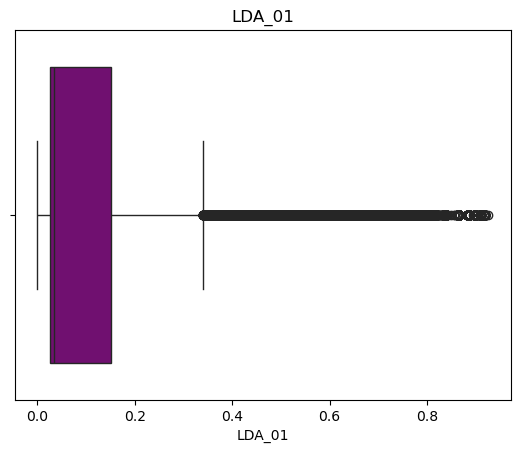

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                12.0             219.0         0.663594               1.0   
3                 9.0             531.0         0.503788               1.0   
25                8.0             266.0         0.572581               1.0   
27               12.0            1225.0         0.385452               1.0   
43               10.0            1081.0         0.428037               1.0   
...               ...               ...              ...               ...   
39602             9.0             475.0         0.558242               1.0   
39619            14.0             428.0         0.512881               1.0   
39620            13.0             413.0         0.556675               1.0   
39637            13.0            1629.0         0.425711               1.0   
39643            10.0             157.0         0.701987               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

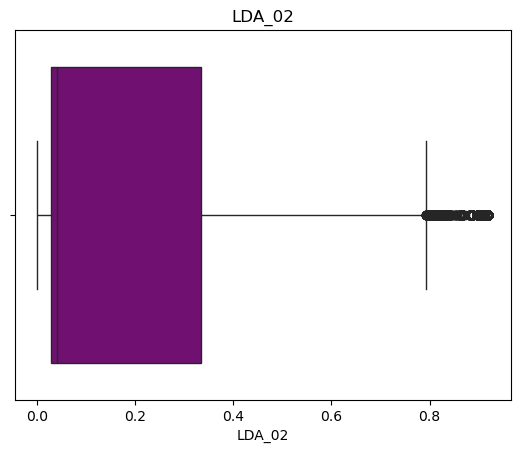

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
9                10.0             231.0         0.636364               1.0   
15               12.0             682.0         0.459542               1.0   
38               11.0             799.0         0.504391               1.0   
67               11.0             317.0         0.611465               1.0   
79               12.0             288.0         0.589474               1.0   
...               ...               ...              ...               ...   
39628            14.0             626.0         0.552504               1.0   
39631            13.0             746.0         0.465306               1.0   
39632            15.0             580.0         0.506261               1.0   
39633             9.0             614.0         0.476033               1.0   
39642             6.0             682.0         0.539493               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

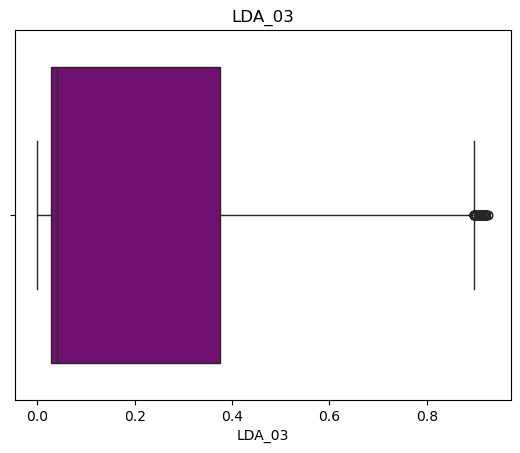

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
96                9.0             168.0         0.778481               1.0   
271              12.0             341.0         0.498471               1.0   
332              10.0             331.0         0.691318               1.0   
342               6.0             279.0         0.650000               1.0   
350              12.0            1267.0         0.502034               1.0   
...               ...               ...              ...               ...   
39541            11.0               0.0         0.000000               0.0   
39546            14.0             466.0         0.520607               1.0   
39569            15.0               0.0         0.000000               0.0   
39580            11.0             459.0         0.534940               1.0   
39584            11.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

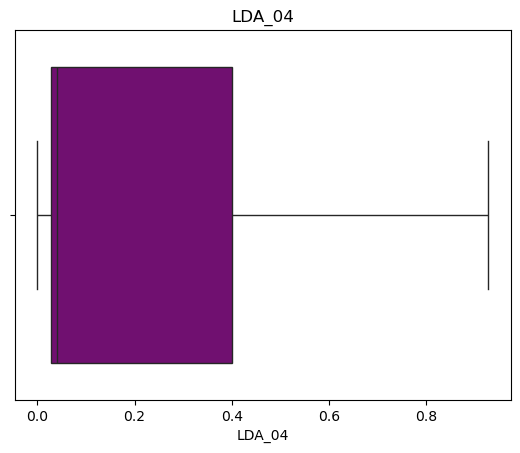

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

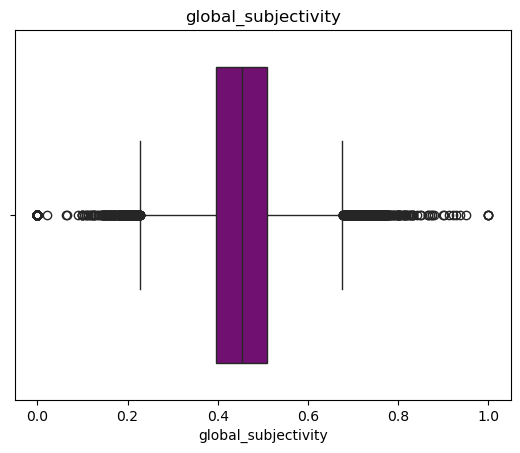

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
2                 9.0             211.0         0.575130               1.0   
111               9.0             233.0         0.552885               1.0   
112               9.0             167.0         0.680982               1.0   
152               7.0             142.0         0.732394               1.0   
221              12.0             160.0         0.647799               1.0   
...               ...               ...              ...               ...   
39601            12.0               0.0         0.000000               0.0   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   
39634             9.0             251.0         0.666667               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

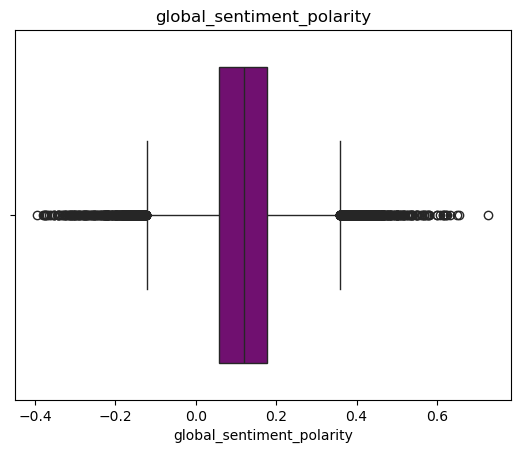

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
178               8.0             211.0         0.607655               1.0   
180               7.0             144.0         0.591549               1.0   
261              13.0             310.0         0.612457               1.0   
274              11.0             221.0         0.660550               1.0   
304              12.0             337.0         0.611987               1.0   
...               ...               ...              ...               ...   
39238             9.0             586.0         0.455342               1.0   
39364            11.0             410.0         0.501235               1.0   
39395            10.0             174.0         0.596154               1.0   
39433            14.0             146.0         0.604651               1.0   
39444             8.0             286.0         0.589744               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

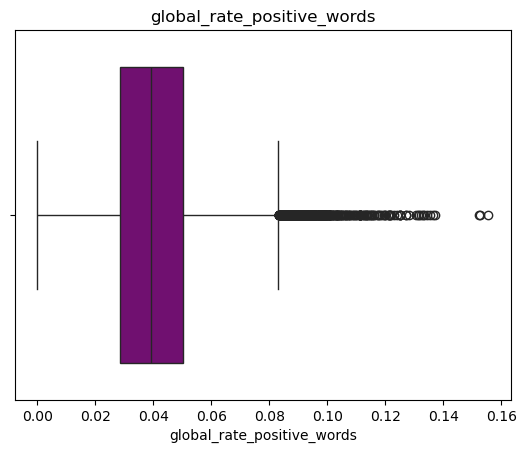

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
7                12.0             989.0         0.433574               1.0   
69                6.0             109.0         0.666667               1.0   
89               12.0             999.0         0.424089               1.0   
101               9.0             825.0         0.438037               1.0   
134               8.0             935.0         0.442037               1.0   
...               ...               ...              ...               ...   
38748            11.0             338.0         0.477564               1.0   
38937             9.0             656.0         0.411856               1.0   
39238             9.0             586.0         0.455342               1.0   
39387            12.0              93.0         0.750000               1.0   
39448            11.0             872.0         0.427562               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

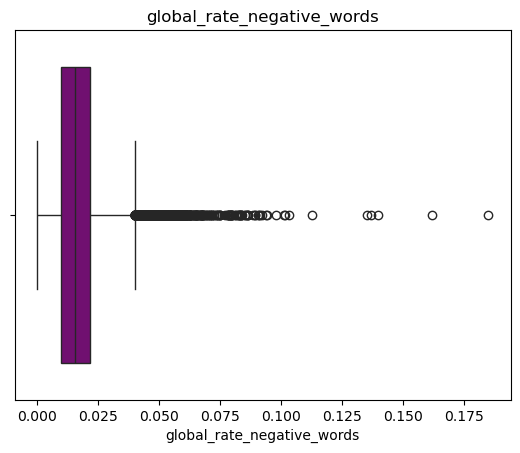

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
13                9.0             285.0         0.744186               1.0   
66                7.0             251.0         0.615702               1.0   
96                9.0             168.0         0.778481               1.0   
115               7.0             263.0         0.623077               1.0   
176              14.0             114.0         0.800000               1.0   
...               ...               ...              ...               ...   
39395            10.0             174.0         0.596154               1.0   
39408            10.0             471.0         0.538803               1.0   
39412            13.0              99.0         0.762887               1.0   
39433            14.0             146.0         0.604651               1.0   
39576            12.0             454.0         0.607477               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

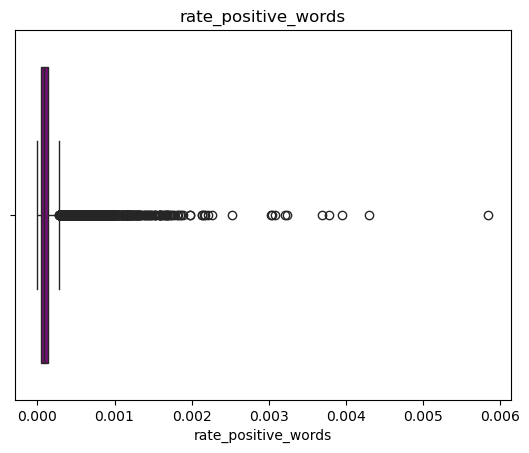

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
8                11.0              97.0         0.670103               1.0   
23               11.0             125.0         0.674797               1.0   
34                8.0             204.0         0.586207               1.0   
39               14.0             194.0         0.764706               1.0   
47               12.0             161.0         0.668831               1.0   
...               ...               ...              ...               ...   
39274            10.0             114.0         0.687500               1.0   
39353            11.0              79.0         0.766234               1.0   
39367            10.0             182.0         0.685083               1.0   
39387            12.0              93.0         0.750000               1.0   
39643            10.0             157.0         0.701987               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

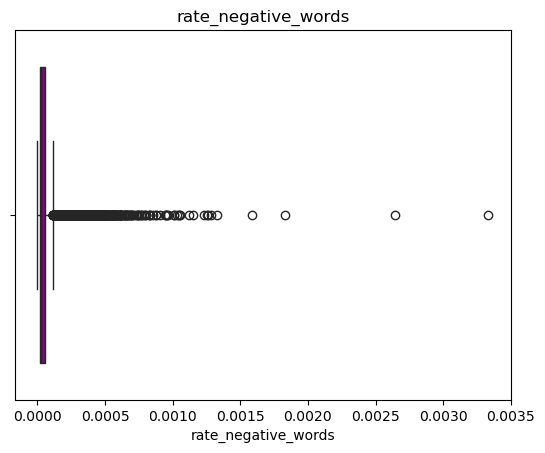

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
8                11.0              97.0         0.670103               1.0   
9                10.0             231.0         0.636364               1.0   
13                9.0             285.0         0.744186               1.0   
66                7.0             251.0         0.615702               1.0   
69                6.0             109.0         0.666667               1.0   
...               ...               ...              ...               ...   
39482             9.0             169.0         0.636905               1.0   
39509             9.0             207.0         0.611650               1.0   
39537             9.0             174.0         0.726190               1.0   
39552             7.0             256.0         0.596838               1.0   
39562             8.0             230.0         0.642534               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

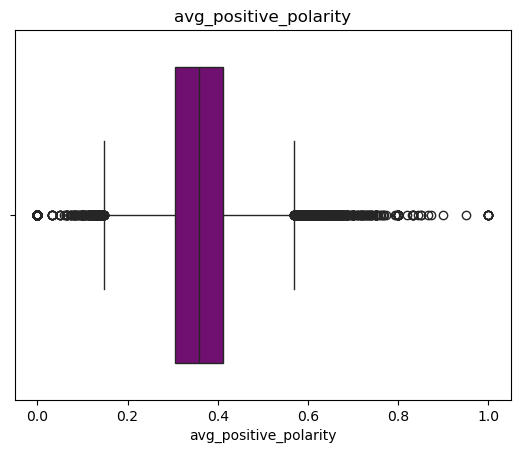

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
145              10.0             138.0         0.753731               1.0   
156              11.0             173.0         0.723529               1.0   
168               9.0             230.0         0.669604               1.0   
180               7.0             144.0         0.591549               1.0   
204               9.0             152.0         0.622378               1.0   
...               ...               ...              ...               ...   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   
39634             9.0             251.0         0.666667               1.0   
39638            11.0             223.0         0.653153               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

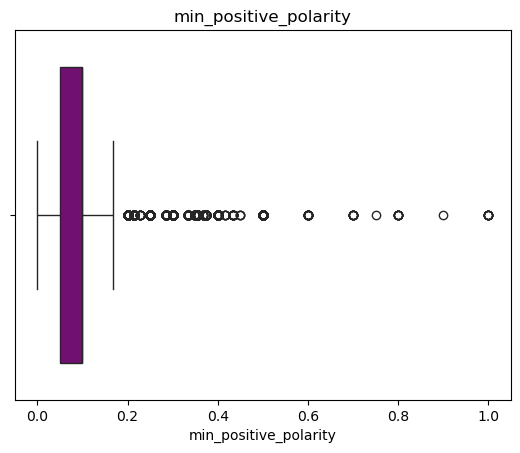

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
8                11.0              97.0         0.670103               1.0   
11               10.0             187.0         0.666667               1.0   
12                9.0             274.0         0.609195               1.0   
25                8.0             266.0         0.572581               1.0   
45               10.0             142.0         0.654676               1.0   
...               ...               ...              ...               ...   
39591            11.0             247.0         0.589212               1.0   
39611            12.0             270.0         0.604651               1.0   
39629            13.0             209.0         0.656863               1.0   
39634             9.0             251.0         0.666667               1.0   
39638            11.0             223.0         0.653153               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

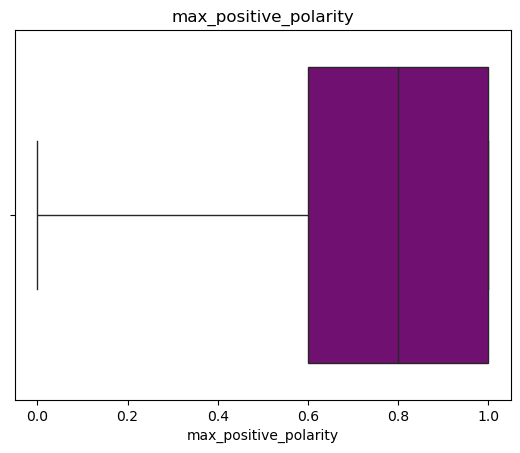

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

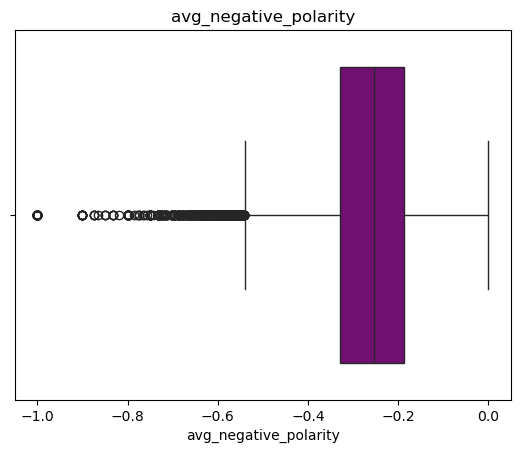

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
152               7.0             142.0         0.732394               1.0   
156              11.0             173.0         0.723529               1.0   
215              13.0             309.0         0.618893               1.0   
327              12.0             138.0         0.644928               1.0   
364              12.0             315.0         0.537162               1.0   
...               ...               ...              ...               ...   
39488            12.0             181.0         0.628571               1.0   
39508            12.0             496.0         0.521368               1.0   
39575            13.0             321.0         0.619048               1.0   
39628            14.0             626.0         0.552504               1.0   
39634             9.0             251.0         0.666667               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

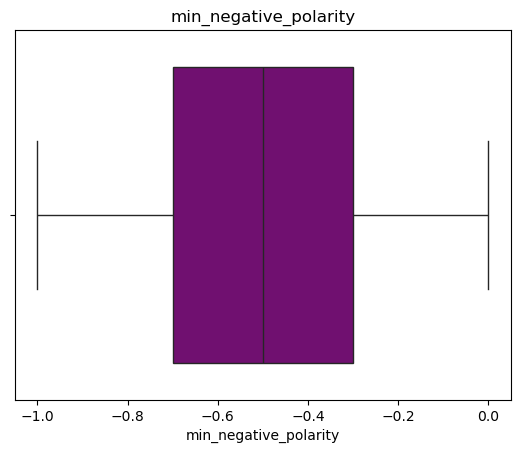

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

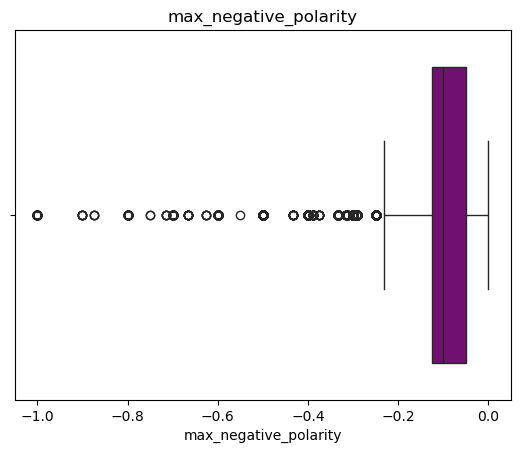

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
34                8.0             204.0         0.586207               1.0   
45               10.0             142.0         0.654676               1.0   
50               11.0             214.0         0.644550               1.0   
57                8.0             130.0         0.821705               1.0   
84                9.0             268.0         0.477273               1.0   
...               ...               ...              ...               ...   
39488            12.0             181.0         0.628571               1.0   
39508            12.0             496.0         0.521368               1.0   
39564            11.0             356.0         0.615607               1.0   
39620            13.0             413.0         0.556675               1.0   
39638            11.0             223.0         0.653153               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

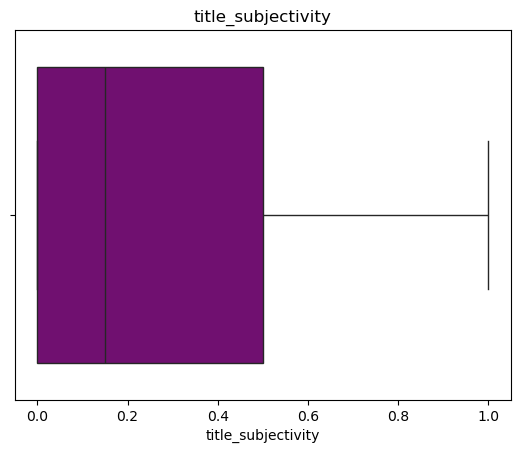

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

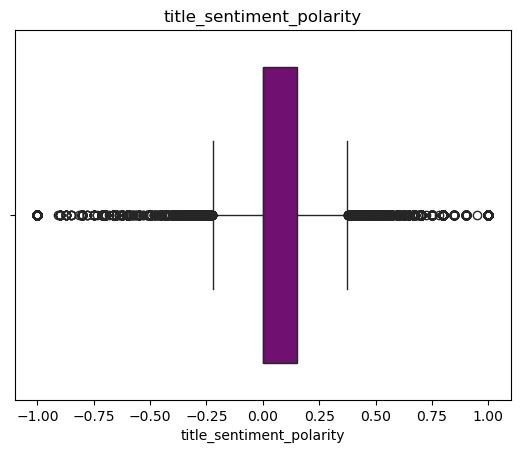

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
7                12.0             989.0         0.433574               1.0   
12                9.0             274.0         0.609195               1.0   
13                9.0             285.0         0.744186               1.0   
14                8.0             259.0         0.562753               1.0   
15               12.0             682.0         0.459542               1.0   
...               ...               ...              ...               ...   
39629            13.0             209.0         0.656863               1.0   
39631            13.0             746.0         0.465306               1.0   
39632            15.0             580.0         0.506261               1.0   
39637            13.0            1629.0         0.425711               1.0   
39640            12.0             328.0         0.696296               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

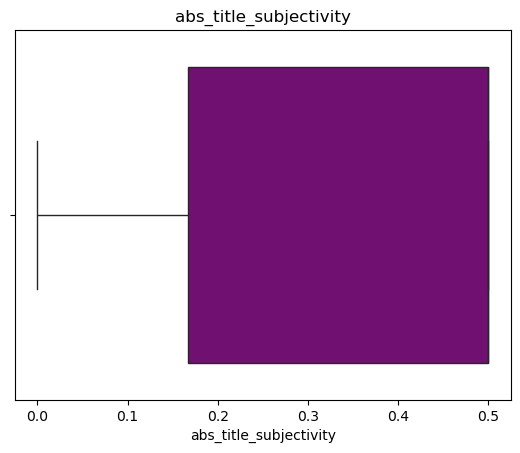

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

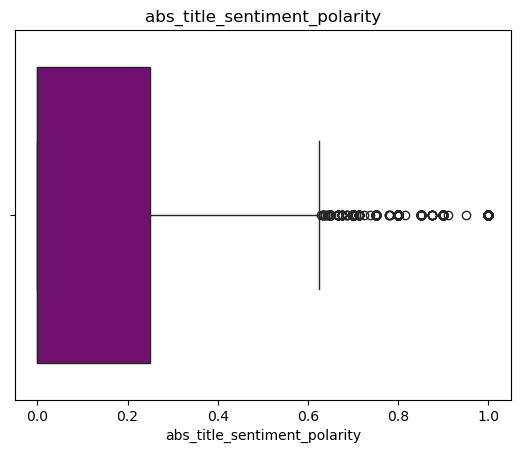

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
12                9.0             274.0         0.609195               1.0   
13                9.0             285.0         0.744186               1.0   
18               11.0             103.0         0.689320               1.0   
33               10.0             597.0         0.531732               1.0   
96                9.0             168.0         0.778481               1.0   
...               ...               ...              ...               ...   
39600            11.0            1166.0         0.508254               1.0   
39604            16.0            1020.0         0.421937               1.0   
39610            11.0             318.0         0.540000               1.0   
39631            13.0             746.0         0.465306               1.0   
39640            12.0             328.0         0.696296               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

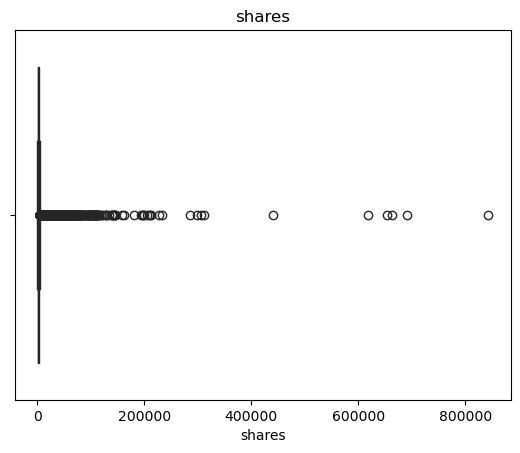

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
13                9.0             285.0         0.744186               1.0   
16                8.0            1118.0         0.512397               1.0   
18               11.0             103.0         0.689320               1.0   
19                8.0            1207.0         0.410579               1.0   
36               10.0            1244.0         0.417547               1.0   
...               ...               ...              ...               ...   
39588            10.0             759.0         0.523352               1.0   
39595            12.0             334.0         0.573171               1.0   
39598            11.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39621             9.0             468.0         0.582781               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

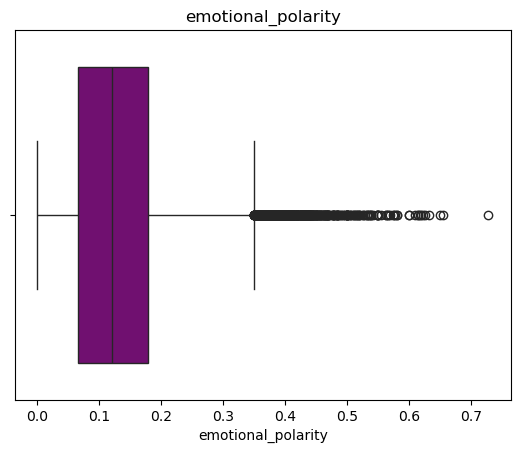

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
180               7.0             144.0         0.591549               1.0   
234               7.0             665.0         0.595166               1.0   
261              13.0             310.0         0.612457               1.0   
274              11.0             221.0         0.660550               1.0   
304              12.0             337.0         0.611987               1.0   
...               ...               ...              ...               ...   
38867            11.0              79.0         0.657895               1.0   
38937             9.0             656.0         0.411856               1.0   
39007            11.0             178.0         0.656977               1.0   
39021             9.0             170.0         0.565476               1.0   
39238             9.0             586.0         0.455342               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

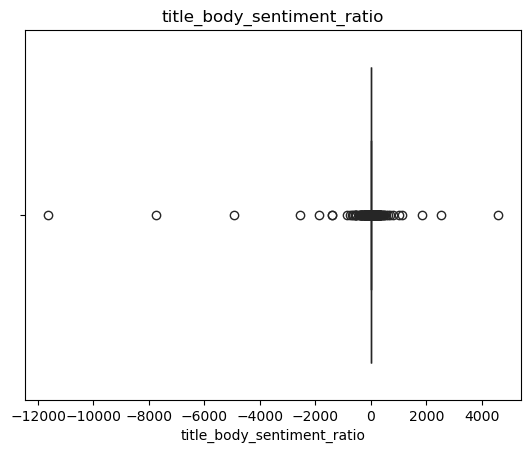

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
12                9.0             274.0         0.609195               1.0   
13                9.0             285.0         0.744186               1.0   
14                8.0             259.0         0.562753               1.0   
15               12.0             682.0         0.459542               1.0   
18               11.0             103.0         0.689320               1.0   
...               ...               ...              ...               ...   
39629            13.0             209.0         0.656863               1.0   
39631            13.0             746.0         0.465306               1.0   
39637            13.0            1629.0         0.425711               1.0   
39640            12.0             328.0         0.696296               1.0   
39641            10.0             442.0         0.516355               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

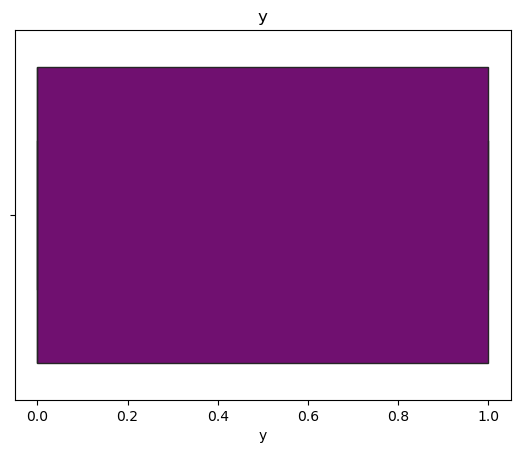

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

In [17]:
# BEFORE OUTLIER HANDLING --> visualize outliers
cols_remaining = df.columns.tolist() # what columns are left in the dataset

num_anomalies_1 = []

# for each of the remaining columns print the anomalies and see if there needs to be any adjustments made --> generally high rates of anomalies
for col in cols_remaining:
    num = anomaly_detection(col, True)
    num_anomalies_1.append(num)

#### Scaling

In [18]:
#CHLOE handling skew and outliers
scaler = RobustScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

#### Smote

In [19]:
#CHLOE TRAIN SMOTE NAN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

#CLASS BALANCING (SMOTE)
cat_indices = [X_train.columns.get_loc(c) for c in binary_cols if c in X_train.columns]
sm = SMOTENC(categorical_features=cat_indices, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#### Feature selection

In [20]:
#CHLOE FEATURE SELECTION
cat_indices = [X_train.columns.get_loc(c) for c in binary_cols if c in X_train.columns]
selector_model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
selector_model.fit(X_train_res, y_train_res)

selection = SelectFromModel(selector_model, threshold="1.25*median", prefit=True)
X_train_selected = selection.transform(X_train_res)
X_test_selected = selection.transform(X_test)

selected_features_names = X_train_res.columns[selection.get_support()]
print(f"Selected {len(selected_features_names)} features.")

Selected 20 features.


/opt/anaconda3/envs/CIS4930-ML/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/CIS4930-ML/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## Training and Testing

In [21]:
# only need to declare the variable once
labels = ['Not Viral', 'Viral']

#### 1. Logistic Regression Model

In [22]:
# implement a logistic regression model --> basic model for classification
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_predict_log = log_model.predict(X_test)

Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.65      0.68      0.66      4017
       Viral       0.65      0.63      0.64      3912

    accuracy                           0.65      7929
   macro avg       0.65      0.65      0.65      7929
weighted avg       0.65      0.65      0.65      7929



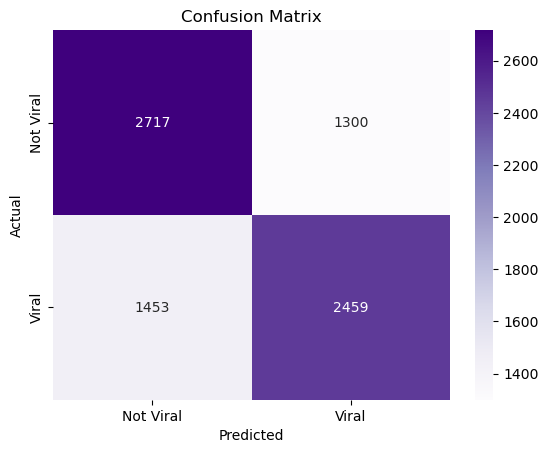

In [23]:
# evaluate linear regression performance
print("Classification Report:\n")
print(classification_report(y_test, y_predict_log, target_names = labels))

cm = confusion_matrix(y_test, y_predict_log)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Purples', xticklabels = labels, yticklabels = labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### 2. KNN

/var/folders/_b/ln_s7k5d40s5s8pfzxghlbb40000gn/T/ipykernel_17178/1719004133.py:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  knn.fit(X_train, y_train.ravel())
/var/folders/_b/ln_s7k5d40s5s8pfzxghlbb40000gn/T/ipykernel_17178/1719004133.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  acc = accuracy_score(y_test.ravel(), pred)
/var/folders/_b/ln_s7k5d40s5s8pfzxghlbb40000gn/T/ipykernel_17178/1719004133.py:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  knn.fit(X_train, y_train.ravel())
/var/folders/_b/ln_s7k5d40s5s8pfzxghlbb40000gn/T/ipykernel_17178/1719004133.py:14: FutureWarning: Series.ravel is deprecated. The underlying 

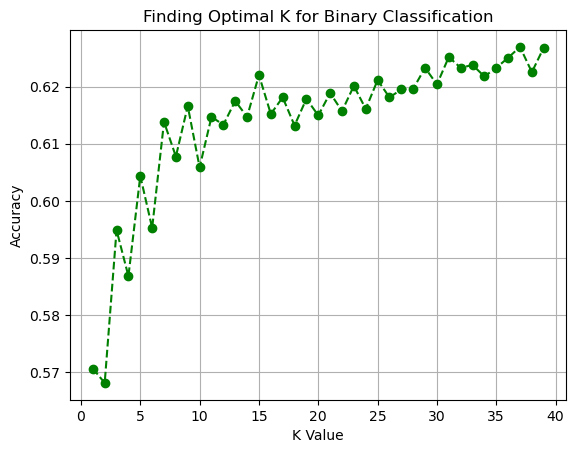

Best K found: 37 with Accuracy: 0.6269


In [24]:
# find the optimal value of k
k_values = range(1, 40)
accuracy_scores = []

for k in k_values:
    # Build KNN classifier for each k
    knn = KNeighborsClassifier(n_neighbors = k, weights = 'uniform')
    knn.fit(X_train, y_train.ravel())
    
    # Predict on test set
    pred = knn.predict(X_test)
    
    # Calculate accuracy
    acc = accuracy_score(y_test.ravel(), pred)
    accuracy_scores.append(acc)

plt.plot(k_values, accuracy_scores, marker='o', linestyle='dashed', color='green')
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.title("Finding Optimal K for Binary Classification")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracy_scores)]
print(f"Best K found: {best_k} with Accuracy: {max(accuracy_scores):.4f}")

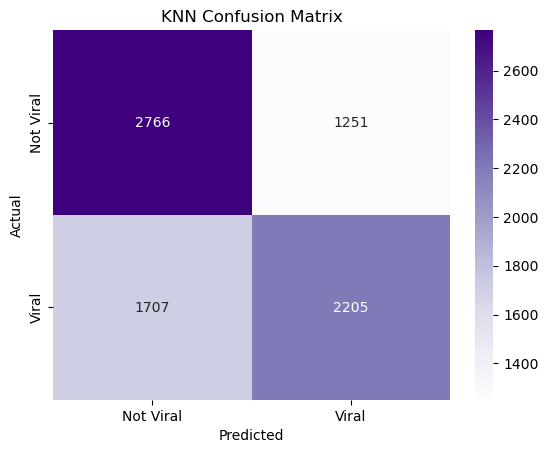

--- FINAL KNN RESULTS (K=37) ---
Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.62      0.69      0.65      4017
       Viral       0.64      0.56      0.60      3912

    accuracy                           0.63      7929
   macro avg       0.63      0.63      0.63      7929
weighted avg       0.63      0.63      0.63      7929



In [25]:
# train knn with optimal k
knn_best = KNeighborsClassifier(n_neighbors=best_k, weights='uniform')

# Fit the model
knn_best.fit(X_train, y_train.values.ravel()) 

# Prediction
y_pred_knn = knn_best.predict(X_test)

# visualize success of knn
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.show()

# Evaluation
print(f"--- FINAL KNN RESULTS (K={best_k}) ---")
print("Classification Report:\n")
print(classification_report(y_test.values.ravel(), y_pred_knn, target_names=labels))

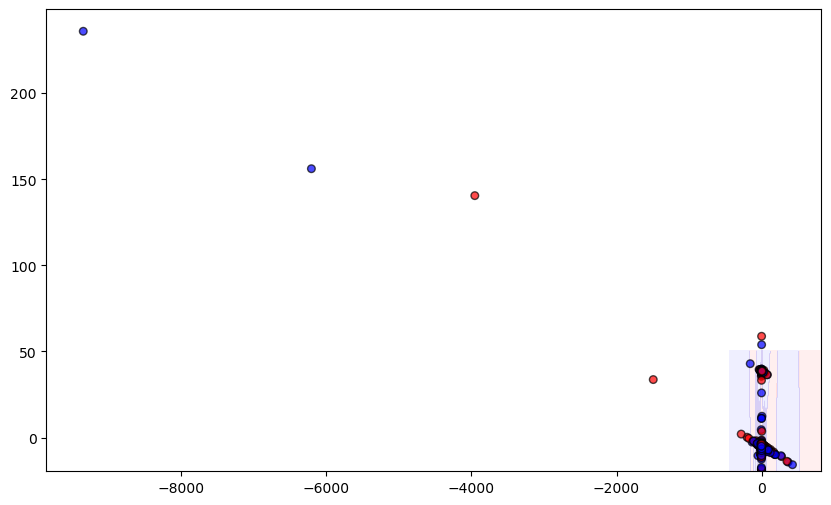

In [26]:
# Subsample to prevent kernel crash
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_vis = X_train.sample(3000, random_state=42)  
y_vis = y_train.loc[X_vis.index]

# PCA on smaller data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_vis)
X_test_pca = pca.transform(X_test)

# Train KNN on subsample
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train_pca, y_vis.values.ravel())

h = 1
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
cmap_light = ListedColormap(['#FFCCCC', '#CCCCFF'])
cmap_bold  = ListedColormap(['#FF0000', '#0000FF'])

plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.3)
plt.scatter(
    X_test_pca[:, 0],
    X_test_pca[:, 1],
    c=y_test.values.ravel(),
    cmap=cmap_bold,
    edgecolor='k',
    s=30,
    alpha=0.7
)

#### 3. Random Forest Classifier


Random Forest Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.67      0.66      0.67      4017
       Viral       0.66      0.68      0.67      3912

    accuracy                           0.67      7929
   macro avg       0.67      0.67      0.67      7929
weighted avg       0.67      0.67      0.67      7929



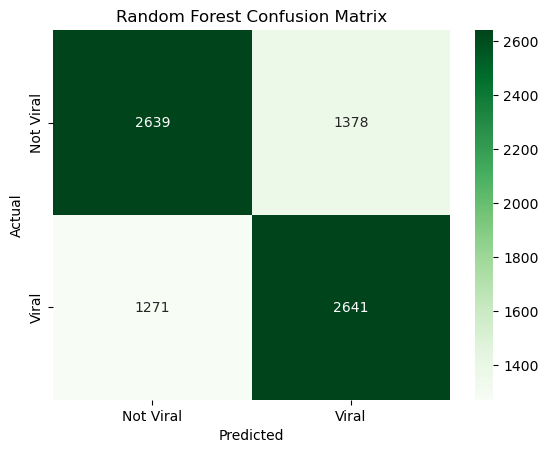

In [27]:
#CHLOE RANDOM FOREST

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20, 
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train_res, y_train_res)

y_predict_rf = rf_model.predict(X_test)

#evaluation
print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, y_predict_rf, target_names=labels))

cm = confusion_matrix(y_test, y_predict_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()
#feature importance
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(15)

/var/folders/_b/ln_s7k5d40s5s8pfzxghlbb40000gn/T/ipykernel_17178/648952430.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')


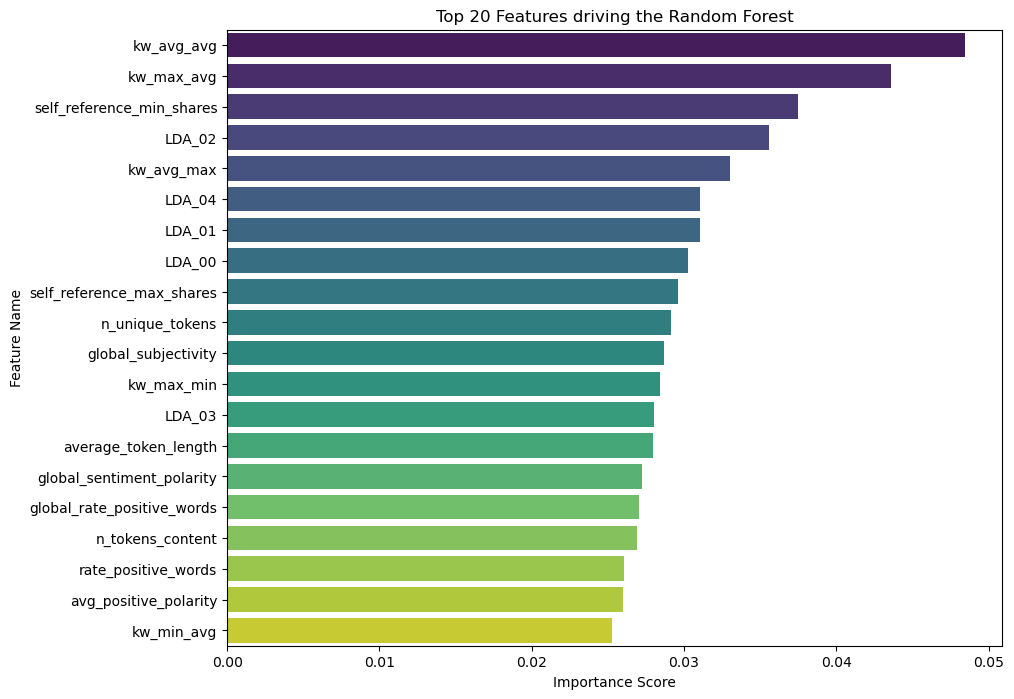

Top 5 Most Important Features:
                      Feature  Importance
21                 kw_avg_avg    0.048470
20                 kw_max_avg    0.043568
22  self_reference_min_shares    0.037466
34                     LDA_02    0.035610
18                 kw_avg_max    0.032989


In [28]:
# Get feature importance from the trained model
importances = rf_model.feature_importances_

# Create a DataFrame to organize them
# Assuming X_train was a DataFrame originally. If it was a numpy array, 
# we generate generic names Feature_0, Feature_1, etc.
try:
    feature_names = X_train.columns
except:
    feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 20 Features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')
plt.title("Top 20 Features driving the Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

print("Top 5 Most Important Features:")
print(feature_imp_df.head(5))

#### 4. XGBoost


Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.66      0.64      0.65      4017
       Viral       0.64      0.65      0.65      3912

    accuracy                           0.65      7929
   macro avg       0.65      0.65      0.65      7929
weighted avg       0.65      0.65      0.65      7929



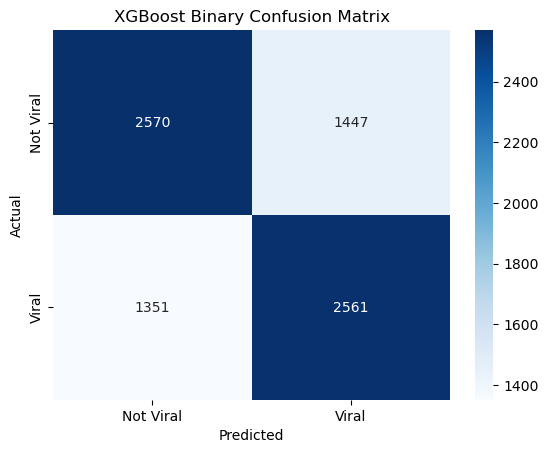

In [29]:
xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='binary:logistic'
)

xgb_model.fit(X_train_selected, y_train_res)

y_pred_xgb = xgb_model.predict(X_test_selected)

# evaluate
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_xgb, target_names=labels))

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Binary Confusion Matrix")
plt.show()

#### 5. Stacking

In [ ]:
# TODO: something here plz

#### 6. Support Vector Machine

In [30]:
# TODO: we still need this pls do this

#### 7. Neural Network

In [31]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_test_tensor  = torch.tensor(y_test.to_numpy(), dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [32]:
# TODO: investigate the architecture of the NN --> increase the complexity to better learn the pattern of the data
class ClassificationNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 51),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(51, 26), # hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(26, num_classes)  # output layer
        )

    def forward(self, x):
        return self.model(x)


In [33]:
model = ClassificationNN(input_dim=X_train_tensor.shape[1], num_classes=3)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Epoch 10/20 | Train Loss: 0.6188 | Test Loss: 0.6199
Epoch 20/20 | Train Loss: 0.6082 | Test Loss: 0.6193
Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.66      0.68      0.67      4017
       Viral       0.66      0.63      0.65      3912

    accuracy                           0.66      7929
   macro avg       0.66      0.66      0.66      7929
weighted avg       0.66      0.66      0.66      7929



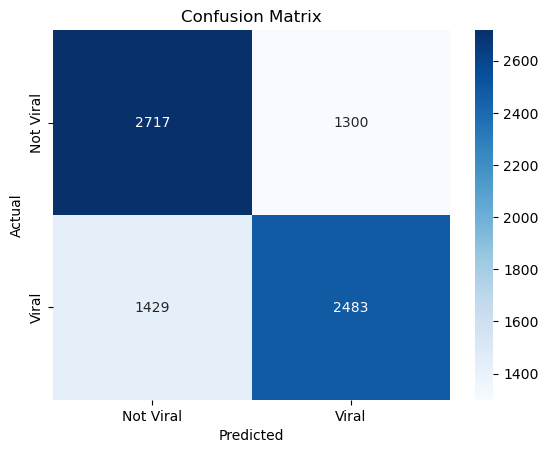

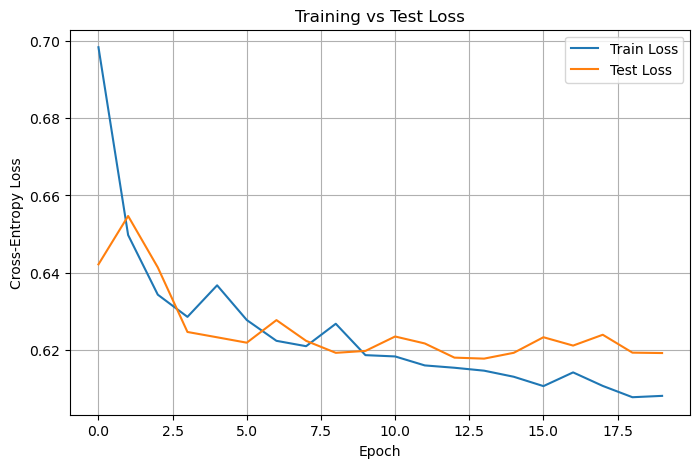

In [34]:
train_losses = []
test_losses = []

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * X_batch.size(0)

    train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Test loss
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_test_loss += loss.item() * X_batch.size(0)

    test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

#evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1)

print("Classification Report:\n")
print(classification_report(y_test_tensor.numpy(), y_pred.numpy(), target_names=labels))

cm = confusion_matrix(y_test_tensor.numpy(), y_pred.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()